<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Linear models

## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting <i>parcelvalue</i>, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and <i>transactiondate</i> is the date when the property was effectively sold. Properties are defined by <i>lotid</i>, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you shouldn't use <i>totaltaxvalue</i>, <i>buildvalue</i> or <i>landvalue</i>, because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. 

+ Using this data build a predictive model for <i>parcelvalue</i> 
+ In your analysis for faster algorithms use the AIC criterion for choosing any hyperparameters 
+ Try a first quick implementation, then try to optimize hyperparameters
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Remove columns '<i>totaltaxvalue</i>', '<i>buildvalue</i>' or '<i>landvalue</i>' from the training and testing set and also '<i>mypointer</i>' from the training set
    + Removing features that have more than 40% of missing data in the training set (remember anything you remove from the training set must be removed form the testing set!) (HINT: data.dropna(axis=1, thresh=round(my_percentage_valid*len(data.index)) - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features (EXTENDED PROJECT ONLY)
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Parcel value prediction made
+ Accuracy of predictions for test properties is calculated (kaggle)
+ Linear Models(s) and LASSO have been used
+ Accuracy itself
+ Data preparation
+ Hyperparameter optimization
+ Code is combined with neat and understandable commentary, with some titles and comments (demonstrate you have understood the methods and the outputs produced)
+ Improved methods from what we discussed in class (properly explained/justified)

# 0.  Initial setup

## 0.1 Load the libraries

In [106]:
# Basic libraries
import numpy as np
import pandas as pd

# Libraries for ploting
import matplotlib.pylab as plt
import seaborn as sns

# Sklearn utilities
import sklearn

# Preprocessing the features
from sklearn.preprocessing import scale as scl

# Linear models
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# Utilities for hyperparameter tuning and acuracy metrics
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error 

## 0.2 Functions for repetitive tasks

In [2]:
# Plot of variables impact
def feature_importance(colnames, coefs, n):
    cols_impact = {'Colname':colnames, 'Coef':coefs}
    cols_impact_df = pd.DataFrame(cols_impact)
    cols_impact_df['Coef'] = cols_impact_df['Coef'].abs()
    cols_impact_df.sort_values('Coef', ascending=False,inplace=True)
    cols_impact_df

    # Plot for the n vars with more impact
    plt.figure(figsize=(8,6))
    sns.barplot(x='Colname', y='Coef', data=cols_impact_df.iloc[:n,])
    plt.xticks(rotation=90)
    
# Function to plot the percentaje of missing values
def missing_plot(df):
    missinvalues = df.isnull().sum(axis=0)/df.shape[0]
    missinvalues.sort_values(inplace=True, ascending=False)

    plt.figure().set_size_inches(12, 6)
    ax = sns.barplot(x=missinvalues.index, y=missinvalues)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right')
    ax.axhline(0.2); ax.axhline(0.4); ax.axhline(0.6); ax.axhline(0.8)
    ax.set_title('Plot of missing values (%)')
    ax.set_xlabel('Column')
    ax.set_ylabel('%')
    plt.show()
    
    
# Function to plot and measure the root mean squared error between observed y and predicted y
def plot_y(y, y_hat):
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    print('RMSE', rmse)

    plt.figure()
    plt.scatter(x=y, y=y_hat)
    plt.plot(y,y,c="red")
    

# 1. Fast estimations

I want to go directly to the elaboration of predictions of our target variable, making the least possible data adjustment, but trying to find good insights that could help me in future models. Mainly, I will follow the steps of the inclass-project and I will not perform any kind of optimization of hyperaparameters

## 1.1 Load the data and measuring the amount of missing data

### 1.1.1 Training data

In [174]:
# Train data
df_train = pd.read_csv("real-estate-valuation-with-linear-models/Regression_Supervised_Train.csv")
print(df_train.shape)
df_train.head()

(24755, 48)


,lotid,logerror,transactiondate,aircond,style,basement,numbath,numbedroom,classbuild,qualitybuild,...,numstories,fireplace,buildvalue,parcelvalue,taxyear,landvalue,totaltaxvalue,taxdelinquencyflag,taxdelinquencyyear,mypointer
0,17214744,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,NaN,...,1.0,NaN,103993.0,142212.0,2015,38219.0,1715.08,NaN,NaN,25711
1,12018724,NaN,NaN,1.0,NaN,NaN,2.0,1,NaN,4.0,...,NaN,NaN,129428.0,301141.0,2015,171713.0,3851.88,NaN,NaN,13268
2,11306699,NaN,NaN,1.0,NaN,NaN,3.0,4,NaN,4.0,...,NaN,NaN,175069.0,235062.0,2015,59993.0,3818.24,Y,11.0,5423
3,11047729,NaN,NaN,1.0,NaN,NaN,2.0,3,NaN,7.0,...,NaN,NaN,162926.0,270543.0,2015,107617.0,3450.67,NaN,NaN,26198
4,17174848,NaN,NaN,NaN,NaN,NaN,3.0,2,NaN,NaN,...,2.0,NaN,180532.0,300886.0,2015,120354.0,3394.26,NaN,NaN,25187


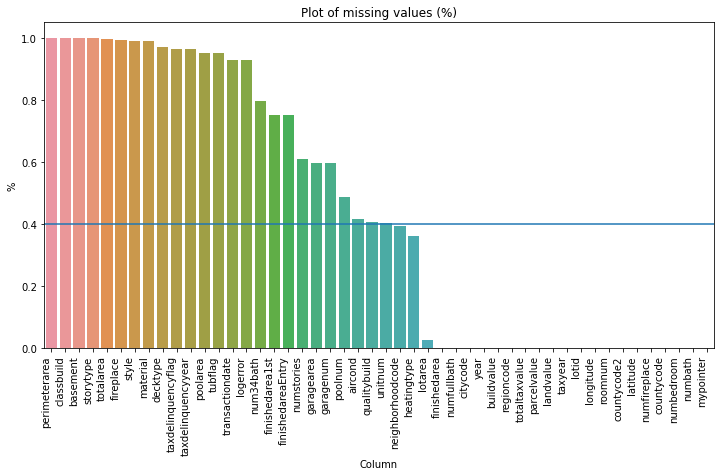

In [24]:
# Let's look at the variables with missing values
missing_plot(df_train)

### 1.1.2 Test Data

In [175]:
df_test = pd.read_csv("real-estate-valuation-with-linear-models/Regression_Supervised_Test2.csv")
print(df_test.shape)
df_test.head()

(2746, 46)


,lotid,logerror,transactiondate,aircond,style,basement,numbath,numbedroom,classbuild,qualitybuild,...,unitnum,year,numstories,fireplace,buildvalue,taxyear,landvalue,totaltaxvalue,taxdelinquencyflag,taxdelinquencyyear
0,11614222,NaN,NaN,1.0,NaN,NaN,3.0,3,NaN,4.0,...,1.0,1975.0,NaN,NaN,165179.0,2015,286865.0,5517.93,NaN,NaN
1,11555888,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,4.0,...,1.0,1948.0,NaN,NaN,295765.0,2015,202798.0,6188.97,NaN,NaN
2,13052987,NaN,NaN,1.0,NaN,NaN,2.0,3,NaN,8.0,...,1.0,1978.0,NaN,NaN,110977.0,2016,225109.0,4245.09,NaN,NaN
3,12448473,NaN,NaN,1.0,NaN,NaN,3.0,3,NaN,4.0,...,1.0,1991.0,NaN,NaN,146117.0,2015,69522.0,2739.32,NaN,NaN
4,12559155,NaN,NaN,1.0,NaN,NaN,1.0,1,NaN,NaN,...,1.0,2004.0,NaN,NaN,183656.0,2015,122438.0,3824.87,NaN,NaN


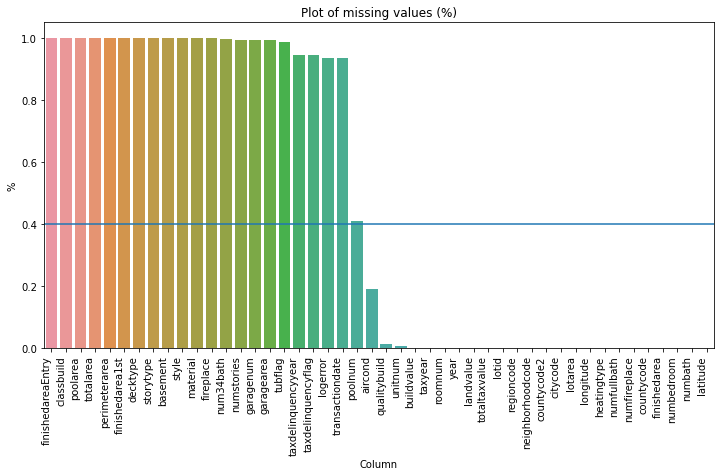

In [26]:
# Let's look at the variables with missing values in test data
missing_plot(df_test)

As the above figures show, both training and testing data have missing values in the most of their features. Actually, we can see that testing data has a percentege above 80% in around 50% of their columns. 

A good fact is that the number of rows in training data is almost 10 times the rows in testing data.

## 1.2 Data cleaning by removing columns and rows with missing data

In [176]:
# Removing specific columns
df_train.drop(['totaltaxvalue', 'buildvalue', 'landvalue', 'mypointer'], axis=1, inplace=True) # mypointer is not in test data

In [177]:
# Removing columns by threshold of missing values (over 40%)
print(df_train.shape)
df_train.dropna(axis=1, thresh=round(0.6*len(df_train.index)), inplace=True) # Keep vars with at least 40% of non-missing values
print(df_train.shape)

(24755, 44)
(24755, 19)


In [178]:
# Removing rows with missing data
print(df_train.shape)
df_train.dropna(axis=0, inplace=True) 
print(df_train.shape)

(24755, 19)
(12560, 19)


In [30]:
# Cheking the missings in training data
df_train.isnull().sum(axis=0)

lotid               0
numbath             0
numbedroom          0
finishedarea        0
countycode          0
numfireplace        0
numfullbath         0
heatingtype         0
latitude            0
longitude           0
lotarea             0
citycode            0
countycode2         0
neighborhoodcode    0
regioncode          0
roomnum             0
year                0
parcelvalue         0
taxyear             0
dtype: int64

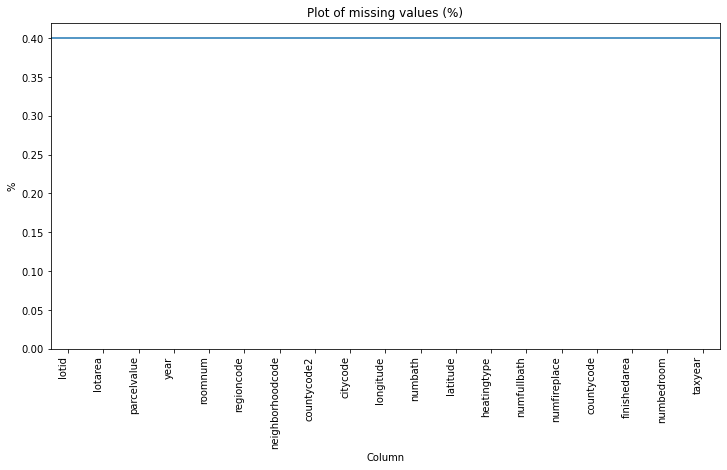

In [31]:
missing_plot(df_train)

## 1.3 Data adjustments for running the regressions

In [179]:
# I should keep the same columns for for both the training and test data set, so I have to remove some colums in the test data
print([i for i in df_train.columns if i not in [j for j in df_test.columns]])
print([i for i in df_test.columns if i not in [j for j in df_train.columns]])

df_test.drop([i for i in df_test.columns if i not in [j for j in df_train.columns]], axis=1, inplace=True)

print([i for i in df_test.columns if i not in [j for j in df_train.columns]])

['parcelvalue']
['logerror', 'transactiondate', 'aircond', 'style', 'basement', 'classbuild', 'qualitybuild', 'decktype', 'finishedarea1st', 'perimeterarea', 'totalarea', 'finishedareaEntry', 'garagenum', 'garagearea', 'tubflag', 'poolnum', 'poolarea', 'storytype', 'num34bath', 'material', 'unitnum', 'numstories', 'fireplace', 'buildvalue', 'landvalue', 'totaltaxvalue', 'taxdelinquencyflag', 'taxdelinquencyyear']
[]


In [34]:
print(df_train.columns)

Index(['lotid', 'numbath', 'numbedroom', 'finishedarea', 'countycode',
       'numfireplace', 'numfullbath', 'heatingtype', 'latitude', 'longitude',
       'lotarea', 'citycode', 'countycode2', 'neighborhoodcode', 'regioncode',
       'roomnum', 'year', 'parcelvalue', 'taxyear'],
      dtype='object')


In [35]:
# Let's check the rows and columns of both training and test data
print(df_train.shape)
print(df_test.shape)

(12560, 19)
(2746, 18)


Something important for me is that the type of each column should be the right one. For example city code is a numeric value but refers to a categorical value, so I prefer to have that column as object and then create dummies of each category

In [118]:
# To see the type of each columns I run ...
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12560 entries, 3 to 24752
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             12560 non-null  int64  
 1   numbath           12560 non-null  float64
 2   numbedroom        12560 non-null  int64  
 3   finishedarea      12560 non-null  float64
 4   countycode        12560 non-null  int64  
 5   numfireplace      12560 non-null  int64  
 6   numfullbath       12560 non-null  float64
 7   heatingtype       12560 non-null  float64
 8   latitude          12560 non-null  int64  
 9   longitude         12560 non-null  int64  
 10  lotarea           12560 non-null  float64
 11  citycode          12560 non-null  float64
 12  countycode2       12560 non-null  int64  
 13  neighborhoodcode  12560 non-null  float64
 14  regioncode        12560 non-null  float64
 15  roomnum           12560 non-null  int64  
 16  year              12560 non-null  float6

In [180]:
# Join the test and train
df_train['From'] = 'train'
df_test['From'] = 'test'
df_f = pd.concat([df_train, df_test], axis=0)
df_f.reset_index(drop=True, inplace=True)

# List of categorical variables
cat_vars_list = ['countycode', 'citycode', 'countycode2', 'neighborhoodcode', 'regioncode']

# Dummies for all non-numeric features in test data
df_f[cat_vars_list] = df_f[cat_vars_list].astype('object') # Convert to categoric data (object)
cat_vars = pd.get_dummies(df_f[cat_vars_list]) # Create dummies of object variables

# Numeric variables scaled using scl. I don't want to affect lotid and parcevalue
numeric_vars_list = [i for i in df_f.select_dtypes('number') if i not in ['lotid','parcelvalue']]
numeric_scaled_vars = pd.DataFrame(scl(df_f[numeric_vars_list]))

# Horizontal join of cat_vars, numerical scaled vars, the target and the id var
df_f = pd.concat([df_f['lotid'], cat_vars, numeric_scaled_vars, df_f['From'], df_f['parcelvalue']], axis=1)

# Separation of the df
df_test_ = df_f[df_f['From'] == 'test']
df_train_ = df_f[df_f['From'] == 'train']

# Target variable and deleting the target and the variable that gave the information of test/training
parcelvalue = df_train_['parcelvalue']
df_test_.drop(['From', 'parcelvalue'], axis=1, inplace=True)
df_train_.drop(['From', 'parcelvalue'], axis=1, inplace=True)

# Set the lotid as index (this way I can still have the information of identification of each house but not using it in the regression)
df_train_.set_index('lotid', inplace=True)
df_test_.set_index('lotid', inplace=True)

print(df_test_.shape)
print(df_train_.shape)
print(df_f.shape)

(2746, 580)
(12560, 580)
(15306, 583)


/Users/andres/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [181]:
# Here I create the numpy array whith the right shapes to use them in sklearn
X_train = scl(np.array(df_train_).reshape(-1,580))
y_train = np.array(parcelvalue).reshape(-1,1)
X_test = scl(np.array(df_test_).reshape(-1,580))

Given that there are houses from a high amount of different locations (neighboorhood, city and region have a many categories) the training and test datasets now have 580 features. Although there are many variables, using theses location variables as dummies its right way to include the information of location a linear regression model. 

## 1.4 Regressions for the first fast estimations

### 1.4.1 Linear regression (without reguralization)

In [289]:
# Creation of the linearregression object with default parameters and fiting in the training data
lr1 = LinearRegression() 
lr1.fit(X_train, y_train)

# Predictions
y_train_p = lr1.predict(X_train) # Predictions over training data
y_test_p = lr1.predict(X_test) # Predictions over test data

RMSE 542730.818825505


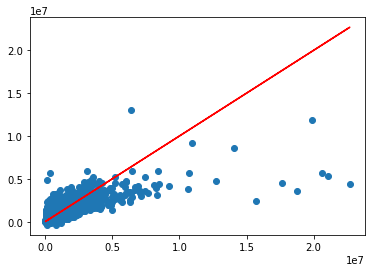

In [290]:
# Measuring the accuracy in the training data 
plot_y(y_train, y_train_p)

In [298]:
# Exporting the prediction in the test data to find the score in the leaderboard

test_predictions_submit_1 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p.reshape(-1,)})
test_predictions_submit_1.to_csv("outputs/test_predictions_submit_11.csv", index = False)

The score in the leaderboard of this prediction is 3149294091862330000 (tends to infinity) very different as the insample estimation of 542730. Since the normal linear regression without any kind of reguralization includes all of the features this model too complex, which is good as an in-sample predictor but fails to predict new data, it does not generalize to all the population of houses but only to this specific sample. 

### 1.4.2 Linear regression (without reguralization) for sqrt of parcelvalue

I want to test if using a transformation of my target value improve the score even for the linear regression with no regularization

In [69]:
lr2 = LinearRegression()
lr2.fit(X_train, np.sqrt(y_train))

# Predictions
y_train_p2 = lr2.predict(X_train)
y_test_p2 = lr2.predict(X_test)

RMSE 542317.6752045734


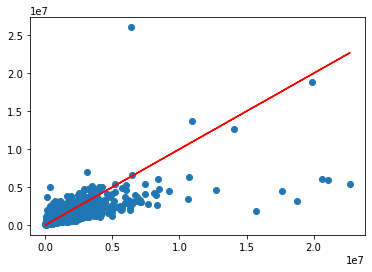

In [70]:
# Predictions in the original scale
y_train_p2 = y_train_p2 ** 2
y_test_p2 = y_test_p2 ** 2

# Plot
plot_y(y_train, y_train_p2)

In [67]:
test_predictions_submit_2 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p2.reshape(-1,)})
test_predictions_submit_2.to_csv("outputs/test_predictions_submit_12.csv", index = False)

Whith this transformation of the parcelvalue the score in the leaderboard does not improve (is 30598799155764800000000000000000). From now on I will test other linear models with regularization.

### 1.4.3 Lasso Regression with default parameters

In [74]:
la1 = Lasso(max_iter = 3000000) # I used default alpha of 1 and I had to increase max_iter because the model was not converging
la1.fit(X_train, y_train)

y_train_p_l1 = la1.predict(X_train)
y_test_p_l1 = la1.predict(X_test)

RMSE 541821.7066380741


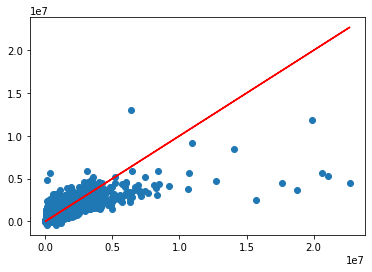

In [76]:
# Plot
plot_y(y_train, y_train_p_l1)

The in-sample root mean squared error (rmse) is simiilar to the one found in the LinearRegression model. Lets see how good is this model for out-sample data according to the learderboard score.

In [77]:
test_predictions_submit_3 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p_l1.reshape(-1,)})
test_predictions_submit_3.to_csv("outputs/test_predictions_submit_13.csv", index = False)

This regression gets a score of 431603.69162 in the leaderboard, wich is a good improvement from the regression without reguralization. It's courious that the score in training is higher than in the leaderboard, which could be a  sing of underfitting, meaning that the model could be too simple because has penalized too many variables. I think and I could get better results by decreasing the alpha, however my goal now is try different fast estimations (hyper paramenter tuning takes long time).

### 1.4.4 Lasso regressión over log of parcel value

Now let's see what happens with a new transformation of parcelvalue wich is the logaritmh of the value. This transformations becomes my target variable like a normal at leats in the graph.

In [182]:
la2 = Lasso(alpha=0.001, max_iter=1000000, random_state=123) # With alpha 0.001 becase the default becomes all Betas to 0
la2.fit(X_train, np.log(y_train))

y_train_p_l2 = np.exp(la2.predict(X_train))
y_test_p_l2 = np.exp(la2.predict(X_test))

RMSE 22921671.247628782


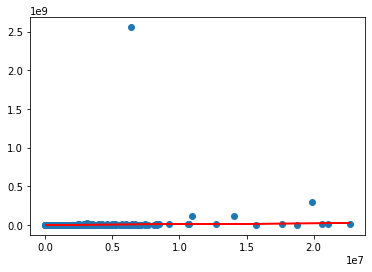

In [103]:
# Plot
plot_y(y_train, y_train_p_l2)

In [106]:
test_predictions_submit_4 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p_l2.reshape(-1,)})
test_predictions_submit_4.to_csv("outputs/test_predictions_submit_14.csv", index = False)

Althougt the insample RMSE is high (It might be because fo the outliers), this model gets a score or 398764 in the leader board. 

Let's see the variables importance.

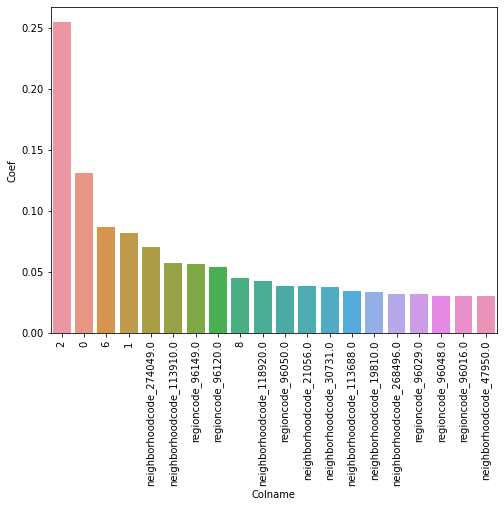

In [111]:
feature_importance(df_train_.columns, la2.coef_, 20)

It's seems like number of room was defined as categorical and its values are the most important ones, together with neighboorhood and region code. Let's try with the square root of parcelvalue.

### 1.4.5 Lasso with squared root of parcel value

In [183]:
la3 = Lasso(alpha= 0.1, max_iter=1000000)
la3.fit(X_train, np.sqrt(y_train))

y_train_p_l3 = la3.predict(X_train) ** 2
y_test_p_l3 = la3.predict(X_test) ** 2

RMSE 542730.0203097562


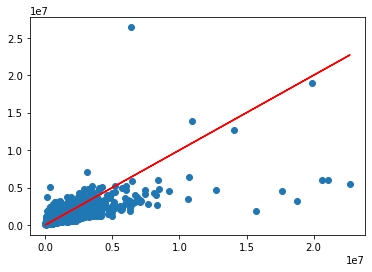

In [129]:
# Plot
plot_y(y_train, y_train_p_l3)

In [131]:
test_predictions_submit_5 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p_l3.reshape(-1,)})
test_predictions_submit_5.to_csv("outputs/test_predictions_submit_15.csv", index = False)

This is also a good submission and has a score of 391079. 

So far the transformations of parcel value by using the logarithm and the squared root run good in the training of the model( they take relatively little time), and perform good in the leaderboard. However, the behavior of the in-sample rmse does not show a relationship with the out-sample score, it should be because of the outliers.

### 1.4.6 New estimation using the average of the last two

Since I have two "good" estimations given the score in the learderboard of the kaggle competition I would like to see if by using the information of both I can have even a better score.

In [135]:
# Join the last two submissions
lasso_2and3 = pd.merge(test_predictions_submit_4, test_predictions_submit_5, on='lotid')
lasso_2and3.head()

,lotid,parcelvalue_x,parcelvalue_y
0,11614222,682676.853261,672011.752044
1,11555888,441671.107010,523430.030166
2,13052987,317821.486312,307189.324289
3,12448473,252359.522662,251016.337152
4,12559155,240676.629152,221521.000408


<AxesSubplot:xlabel='parcelvalue_x', ylabel='parcelvalue_y'>

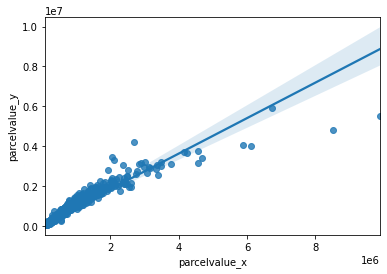

In [136]:
sns.regplot(x='parcelvalue_x', y='parcelvalue_y', data=lasso_2and3)

In [137]:
# Maybe using the average of both could give a good score
test_predictions_submit_6 = test_predictions_submit_5.copy()
test_predictions_submit_6['parcelvalue'] = (lasso_2and3['parcelvalue_x'] + lasso_2and3['parcelvalue_y'])/2

test_predictions_submit_6.to_csv("outputs/test_predictions_submit_16.csv", index = False)

As expected with this submission the score improves and now is 388961. Now let's see if by dealing with the outliers I can improve my estimations in test data.

## 1.5 Simple adjustment of outliers

I lack of the knowledge in methodologies to deal with outliers in this kind of taks, however I would like to test if removing some outliers in parcel value improves the scores in in-sample and out-sample predictions.

### 1.5.1 Data adjustment

In [ ]:
# Finding the highest and lowest values of parcelvalue

In [142]:
# Lowest values
print(df_train['parcelvalue'].sort_values()[:10])

23061    16474.0
23448    18306.0
170      18311.0
15872    22162.0
9818     23409.0
19004    24232.0
15403    24627.0
8509     25938.0
11924    27282.0
19909    30365.0
Name: parcelvalue, dtype: float64


In [147]:
# Highest values
print(df_train['parcelvalue'].sort_values(ascending=False)[60:70])

5133     4885461.0
20893    4871198.0
9267     4850000.0
8599     4830125.0
19506    4822437.0
70       4695271.0
14169    4686807.0
22723    4624955.0
24505    4589909.0
11827    4465499.0
Name: parcelvalue, dtype: float64


Houses of 20 million ??. Personally I think that more than 5 million is too much. Let's not working with those houses and we will see what happens.

Let's adjust the data to run new models.

In [148]:
# From df_F separate the into train and test
df_test_NO = df_f[df_f['From'] == 'test']
df_train_NO = df_f[df_f['From'] == 'train']

# Delete houses higher than 5 million
df_train_NO = df_train_NO[df_train_NO['parcelvalue']<5000000]

parcelvalue = df_train_NO['parcelvalue']
df_test_NO.drop(['From', 'parcelvalue'], axis=1, inplace=True)
df_train_NO.drop(['From', 'parcelvalue'], axis=1, inplace=True)

df_train_NO.set_index('lotid', inplace=True)
df_test_NO.set_index('lotid', inplace=True)

print(df_test_.shape)
print(df_train_.shape)
print(df_f.shape)

(2746, 580)
(12560, 580)
(15306, 583)


/Users/andres/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [149]:
X_train_NO = scl(np.array(df_train_NO).reshape(-1,580))
y_train_NO = np.array(parcelvalue).reshape(-1,1)
X_test_NO = scl(np.array(df_test_NO).reshape(-1,580))

### 1.5.2 Lasso with squared root of parcel value after deleting parcelvalue > 5000000

In [155]:
# Estimation over the squared root
la4 = Lasso(alpha= 0.1, max_iter=1000000)
la4.fit(X_train_NO, np.sqrt(y_train_NO))

y_train_p_l4 = la4.predict(X_train_NO) ** 2
y_test_p_l4 = la4.predict(X_test_NO) ** 2

RMSE 327964.2285515777


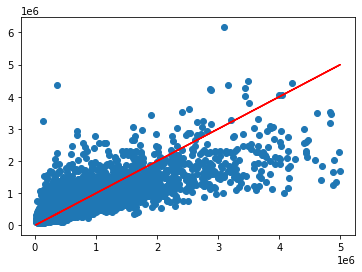

In [156]:
# Plot
plot_y(y_train_NO, y_train_p_l4)

In [157]:
test_predictions_submit_7 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p_l4.reshape(-1,)})
test_predictions_submit_7.to_csv("outputs/test_predictions_submit_17.csv", index = False)

This approximation gets a score of 418031.81808, which is not an improvement from the model with outliers.

### 1.5.3 Lasso with log of parcel value after deleting parcevalue > 5000000

In [159]:
# Estimation over the squared root
la5 = Lasso(alpha= 0.001, max_iter=1000000, random_state=123)
la5.fit(X_train_NO, np.log(y_train_NO))

y_train_p_l5 = np.exp(la5.predict(X_train_NO))
y_test_p_l5 = np.exp(la5.predict(X_test_NO))

RMSE 470155.85670159385


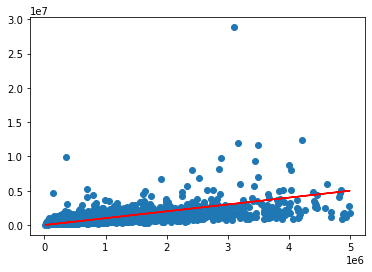

In [160]:
# Plot
plot_y(y_train_NO, y_train_p_l5)

In [161]:
test_predictions_submit_8 = pd.DataFrame({"lotid": df_test_.index, "parcelvalue": y_test_p_l5.reshape(-1,)})
test_predictions_submit_8.to_csv("outputs/test_predictions_submit_18.csv", index = False)

This submitssion gets a score of 406861, slighly higher than the version with outliers. What is good here is that the in-sample rmse is more similar to the out-sample one in the learderboard.

### 1.5.4 Plots of residuals

RMSE 790391.2900368316


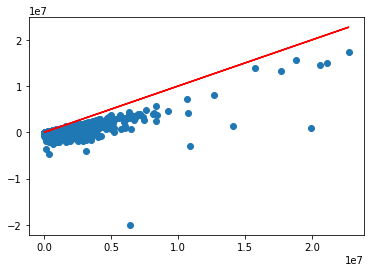

In [182]:
# Lets plot the residual of my best models so far
res_l3 = np.add(y_train.reshape(-1), y_train_p_l3.reshape(-1) *-1)
plot_y(y_train.reshape(-1), res_l3)

RMSE 23015211.969876785


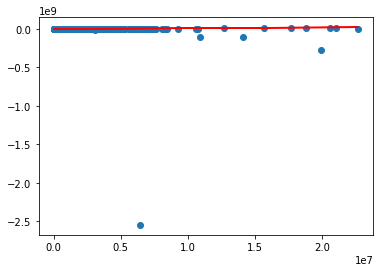

In [184]:
# Lets plot the residual of my best models so far
res_l2 = np.add(y_train.reshape(-1), y_train_p_l2.reshape(-1) *-1)
plot_y(y_train.reshape(-1), res_l2)

As expected our models are not good to predict the highest values of parcel value.

# 2. Trying more robust estimations

So far I have gotten relatively good results with simple approximations, however I haven't done any exploration of the data nor any imputation of missing data or hyper-parameter tuning, lets do this work.

## 2.1 Loading the data and dealing with missing values

In [61]:
# Load the training the data again

# Train data
df_train = pd.read_csv("real-estate-valuation-with-linear-models/Regression_Supervised_Train.csv")
print(df_train.shape)
print(df_train.info())
df_train.head()

(24755, 48)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24755 entries, 0 to 24754
Data columns (total 48 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lotid               24755 non-null  int64  
 1   logerror            1763 non-null   float64
 2   transactiondate     1763 non-null   object 
 3   aircond             14464 non-null  float64
 4   style               233 non-null    float64
 5   basement            56 non-null     float64
 6   numbath             24755 non-null  float64
 7   numbedroom          24755 non-null  int64  
 8   classbuild          18 non-null     float64
 9   qualitybuild        14654 non-null  float64
 10  decktype            712 non-null    float64
 11  finishedarea1st     6143 non-null   float64
 12  finishedarea        24692 non-null  float64
 13  perimeterarea       0 non-null      float64
 14  totalarea           62 non-null     float64
 15  finishedareaEntry   6143 non-null   float

,lotid,logerror,transactiondate,aircond,style,basement,numbath,numbedroom,classbuild,qualitybuild,...,numstories,fireplace,buildvalue,parcelvalue,taxyear,landvalue,totaltaxvalue,taxdelinquencyflag,taxdelinquencyyear,mypointer
0,17214744,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,NaN,...,1.0,NaN,103993.0,142212.0,2015,38219.0,1715.08,NaN,NaN,25711
1,12018724,NaN,NaN,1.0,NaN,NaN,2.0,1,NaN,4.0,...,NaN,NaN,129428.0,301141.0,2015,171713.0,3851.88,NaN,NaN,13268
2,11306699,NaN,NaN,1.0,NaN,NaN,3.0,4,NaN,4.0,...,NaN,NaN,175069.0,235062.0,2015,59993.0,3818.24,Y,11.0,5423
3,11047729,NaN,NaN,1.0,NaN,NaN,2.0,3,NaN,7.0,...,NaN,NaN,162926.0,270543.0,2015,107617.0,3450.67,NaN,NaN,26198
4,17174848,NaN,NaN,NaN,NaN,NaN,3.0,2,NaN,NaN,...,2.0,NaN,180532.0,300886.0,2015,120354.0,3394.26,NaN,NaN,25187


### 2.1.1 Analysis of missing data

In [4]:
# I want to see the number of missing with their respective meaning and the type of the column

# read the dictionary of vars
dic_vars = pd.read_excel("real-estate-valuation-with-linear-models/Case_data_dictionary.xlsx")

# frame of missing values
df_missings = (df_train.isnull().sum(axis=0)/df_train.shape[0]).to_frame().reset_index()
df_missings.rename(columns={'index' : 'Equivalence', 0:'per_missing'}, inplace=True)

# frame of dtypes
df_dtypes = df_train.dtypes.to_frame().reset_index()
df_dtypes.rename(columns={'index':'Equivalence', 0:'Type'}, inplace=True)


# Merges
dic_vars = pd.merge(df_missings, dic_vars, on = 'Equivalence', how='left')
dic_vars = pd.merge(dic_vars, df_dtypes, on = 'Equivalence', how='left')
dic_vars.sort_values(by=['per_missing'], ascending=False)

,Equivalence,per_missing,Description,Type
13,perimeterarea,1.000000,Perimeter living area,float64
8,classbuild,0.999273,"The building framing type (steel frame, wood f...",float64
5,basement,0.997738,Finished living area below or partially below...,float64
33,storytype,0.997738,Type of floors in a multi-story house (i.e. b...,float64
14,totalarea,0.997495,Total area,float64
39,fireplace,0.992406,Is a fireplace present in this home,object
4,style,0.990588,"Architectural style of the home (i.e. ranch, ...",float64
35,material,0.989941,What type of construction material was used t...,float64
10,decktype,0.971238,Type of deck (if any) present on parcel,float64
45,taxdelinquencyflag,0.964209,Property taxes for this parcel are past due as...,object


From the table above I found some ideas of variables to drop, and others to fill.

In [62]:
# Since I have to do the feature enginering with train and test data I will concatenate both tables, (I will split them again afterwards)
df_test = pd.read_csv("real-estate-valuation-with-linear-models/Regression_Supervised_Test2.csv")

df_test['From'] = 'test'
df_train['From'] = 'training'


print('Rows', df_test.shape[0] + df_train.shape[0])
print('Columns', max(df_test.shape[1], df_train.shape[1]))
df = pd.concat([df_train, df_test])
df.reset_index(drop=True)
print(df.shape)

Rows 27501
Columns 49
(27501, 49)


In [63]:
# I want to know which variables I need to delete (because there's one that is not in test data)
[i for i in df_train.columns if i not in [j for j in df_test.columns]]

['parcelvalue', 'mypointer']

In [64]:
# Need to delete mypointer, among other features that I should not use
# Let's delete those columns
df.drop(['num34bath', 'transactiondate', 'material', 'mypointer', 'totaltaxvalue', 'buildvalue', 'landvalue'], axis=1, inplace=True)
df.shape

(27501, 42)

In [65]:
# Since there are categorical data as numeric I will change the type of those columns
to_cat_vars = ['countycode', 'countycode2', 'regioncode', 'citycode', 'heatingtype', 'neighborhoodcode', 'aircond', 'poolnum', 'decktype', 'qualitybuild']
df[to_cat_vars] = df[to_cat_vars].astype('object')
df[to_cat_vars].dtypes

countycode          object
countycode2         object
regioncode          object
citycode            object
heatingtype         object
neighborhoodcode    object
aircond             object
poolnum             object
decktype            object
qualitybuild        object
dtype: object

### 2.1.2 Analysis of location variables

Since the location of a house is a good indicator of its value I will pay attention to the missing value over countycode, regioncode, citycode and neighborhoodcode.

#### 2.1.2.1. Plots of points with missing and non-missing values of location variables

I want to plot the points (longitude and latitude) of the houses that have values and next, the points of the houses taht do not have information in the location variables.

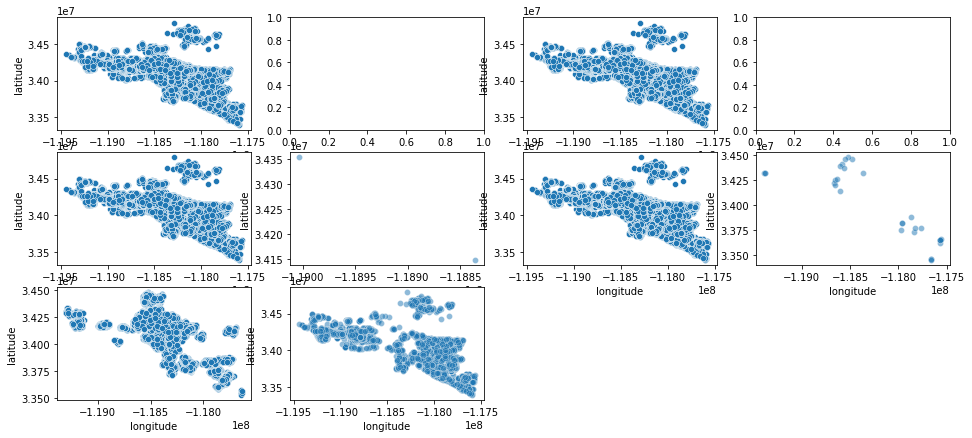

In [66]:
# Ploting the variables of location (county, city, region, neighboor)
location_vars_list = ['countycode', 'countycode2', 'regioncode', 'citycode', 'neighborhoodcode']
j=0
plt.figure(figsize=(16,12))
for i, col in enumerate(location_vars_list):
    for value in [False, True]:
        j +=1
        plt.subplot(5,4,j)
        if value == False:
            sns.scatterplot(x='longitude', y='latitude', data=df.loc[df[col].isnull() == value])
        else:
            sns.scatterplot(x='longitude', y='latitude', alpha=0.5, data=df.loc[df[col].isnull() == value])

The first row shows that countycode and countycode2 dont have missing values. 

The second row shows that regioncode has few missings in extreme locations. By its part, city code has also few missings.

The third row shows the structure of missings for neighborhood. Since the missing and non-missing points are close to each other i would like to fill the missing values according to the neighborcode of the closest point.

#### 2.1.2.2 Filling the missing in location variables

In [8]:
# To fill the missing values of neighborcode I will compute the euclidean distances based on longitued and latitud, 
# for that I will use a function of skalearn

from sklearn.metrics.pairwise import euclidean_distances

ed_test = df[['longitude','latitude']] # df only with 

mat_ed_test = euclidean_distances(ed_test) # Creates a matrix of n x n with the distances of all of the points
distances = mat_ed_test[:,0] # With the distances to the firs row in enough for me
distances

array([     0.        , 549646.94664848, 888266.62368008, ...,
       496087.50776451, 528722.68625433, 283866.23118645])

In [67]:
df['Distances'] = distances # Adding the distances to the main dataframe
# Delete the elements (they comsume a lot of space in the ram)
#del mat_ed_test

In [68]:
# I want to see if what i did makes sense 
df.sort_values(by='Distances', axis=0, inplace=True)
df[['longitude', 'latitude', 'neighborhoodcode', 'Distances']].head(20)

,longitude,latitude,neighborhoodcode,Distances
0,-118914689,34191029,46736.0,0.000000
3164,-118914783,34191705,46736.0,682.501282
20437,-118914964,34191813,46736.0,830.830909
22180,-118913851,34189400,46736.0,1831.906111
10133,-118914269,34193024,46736.0,2038.730978
20723,-118912260,34190673,46736.0,2454.949287
18794,-118913724,34193434,46736.0,2591.379555
6118,-118915928,34193509,46736.0,2772.277042
20157,-118914822,34188239,46736.0,2793.168094
17448,-118912448,34189101,46736.0,2956.224619


For me if the variable has few missing is ok, it could be useful information
In neighboorhood seems like the the missing points are close to the points with information, accoding to this I am gonna fill 
NA in neighboorhood but I will keep the info of neighboorhood without information (NA) in a second var

In [69]:
# Now I fill missing values of neighboor code according to the last non-missing value (bfill)
# I also want to have the information of neighborcode that has missin values
df['neighborhoodcode2'] = df['neighborhoodcode']
print(df['neighborhoodcode2'].isnull().sum())
df['neighborhoodcode2'] = df['neighborhoodcode2'].fillna(method='bfill')
print(df['neighborhoodcode2'].isnull().sum())

9728
117


In [70]:
# Given that bfill did not fill all of the missing, the rest missing values 
# will be filled with the next non-missin value (ffill)
df['neighborhoodcode2'] = df['neighborhoodcode2'].fillna(method='ffill')
print(df['neighborhoodcode2'].isnull().sum())

0


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

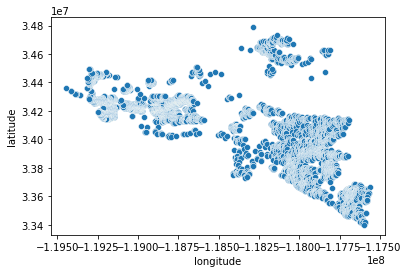

In [205]:
# Plot to see the effect of the imputation of missings 
# Missing points of neighborhoodcode
sns.scatterplot(x='longitude', y='latitude', data=df.loc[df['neighborhoodcode'].isnull()])

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

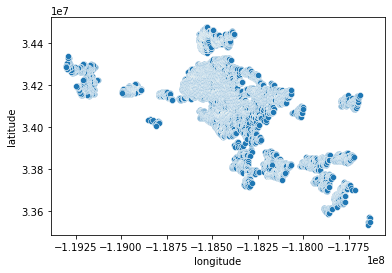

In [206]:
# Non-missing points of neighborhoodcode
sns.scatterplot(x='longitude', y='latitude', data=df.loc[df['neighborhoodcode'].isnull()==False])

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

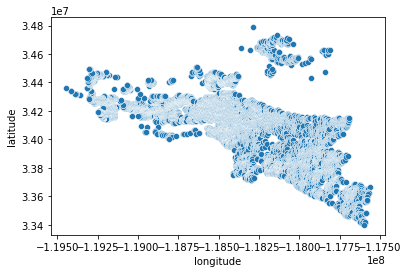

In [207]:
# The map now that I fill missings
sns.scatterplot(x='longitude', y='latitude', data=df)

Not sure about how good was this, but It might work

In [71]:
# I will fill the rest of nas in the location columns as missing (imformation that can be useful in the future)
print(df[location_vars_list].isnull().sum())
df[location_vars_list] = df[location_vars_list].fillna('missing') 
print(df[location_vars_list].isnull().sum())

countycode             0
countycode2            0
regioncode             2
citycode              31
neighborhoodcode    9728
dtype: int64
countycode          0
countycode2         0
regioncode          0
citycode            0
neighborhoodcode    0
dtype: int64


#### 2.1.2.3 Decreasing the number of categories for location variables

In [72]:
# If the count for categories is lower than the percentil 20 then those categories are a new one (other)
print(df[location_vars_list].nunique())
for var in location_vars_list:
    var_df = df[var].value_counts().to_frame().reset_index()
    list_var = list(var_df.loc[var_df[var] < var_df[var].quantile(q=0.2)]['index'])
    df[var] = np.where(df[var].isin(list_var), 'Other', df[var])
    
print(df[location_vars_list].nunique())

countycode            3
countycode2           3
regioncode          372
citycode            155
neighborhoodcode    457
dtype: int64
countycode            3
countycode2           3
regioncode          302
citycode            126
neighborhoodcode    366
dtype: int64


### 2.1.2 Analysis of missing values over other variables

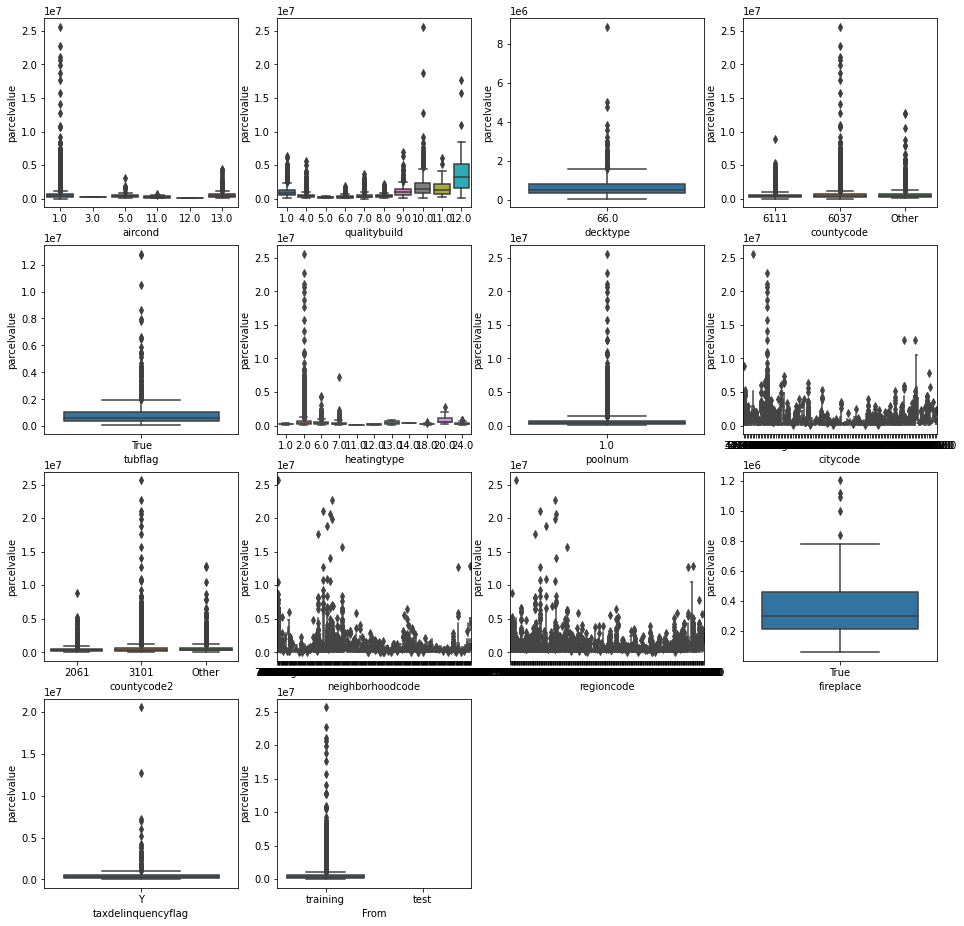

In [214]:
# Lets plot the vars and see what we have

# Lets see what's the behaviour of our y with some cat variables
cat_var_list = df.select_dtypes('object')

plt.figure(figsize=(16,16))
for i,col in enumerate(cat_var_list):
    plt.subplot(4,4,i+1)
    sns.boxplot(x=col, y='parcelvalue',data=df)

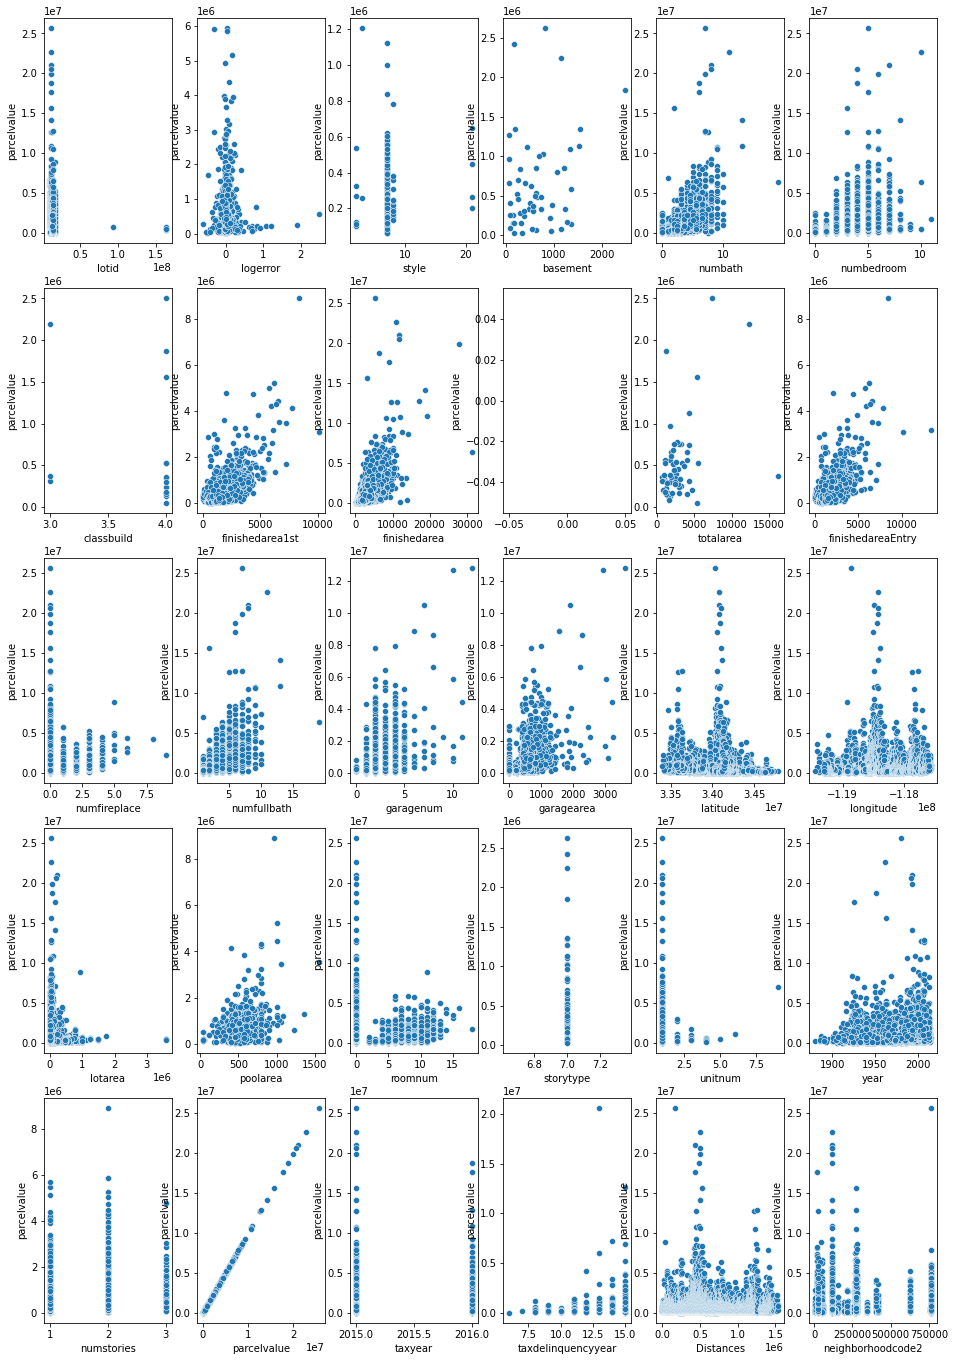

In [215]:
# Lets see what's the behaviour of our y with some cat variables
num_var_list = df.select_dtypes('number').columns

plt.figure(figsize=(16,24))
for i,col in enumerate(num_var_list):
    plt.subplot(5,6,i+1)
    sns.scatterplot(x=col, y='parcelvalue', data=df)

There are some vars that looks like they are important to predict parcelvalue, lets try to see if we can use them according to the amount of missing values

In [73]:
good_vars = ['qualitybuilding', 'basement', 'numbath', 'numbedrooms', 'finishedarea1st', 'finishedarea', 'finishedareaEntry', 
'numfullbaths', 'garagenum', 'garagearea', 'poolarea', 'year', 'taxdelinquencyyear']
dic_vars[dic_vars['Equivalence'].isin(good_vars)].sort_values(by='per_missing', axis=0)


,Equivalence,per_missing,Description,Type
6,numbath,0.000000,Number of bathrooms in home including fractio...,float64
37,year,0.000485,The Year the principal residence was built,float64
12,finishedarea,0.002545,Finished living area,float64
19,garagenum,0.596284,Total number of garages on the lot including ...,float64
20,garagearea,0.596284,Total number of square feet of all garages on...,float64
11,finishedarea1st,0.751848,Size of the finished living area on the first...,float64
15,finishedareaEntry,0.751848,Size of the finished living area on the first...,float64
27,poolarea,0.951283,Total square footage of all pools on property,float64
46,taxdelinquencyyear,0.964209,Year for which the unpaid propert taxes were due,float64
5,basement,0.997738,Finished living area below or partially below...,float64


In [74]:
# The percentages of missings in pool and garagenum could be consistent with the total portion of houses that don have a pool or garage
print(df[['poolnum', 'garagenum']].isnull().sum())
df['poolnum'] = np.where(df['poolnum'].isnull(), 0, df['poolnum'])
df['garagenum'] = np.where(df['garagenum'].isnull(), 0, df['garagenum'])
print(df[['poolnum', 'garagenum']].isnull().sum())

poolnum      13162
garagenum    17489
dtype: int64
poolnum      0
garagenum    0
dtype: int64


In [75]:
# Pool area with 0 if does not have a pool
print(df['poolarea'].isnull().sum())
df['poolarea'] = np.where(df['poolnum'] == 0, 0, df['poolarea'])
print(df['poolarea'].isnull().sum())

26295
13133


There's still a lot of missing value in poolarea.

In [76]:
# Garage area with 0 if does not have a garage, and fill nas with the mean
print(df['garagearea'].isnull().sum())
df['garagearea'] = np.where(df['garagenum'] == 0, 0, df['garagenum'])
df['garagearea'] = np.where(df['garagearea'].isnull(), df['garagearea'].mean(), df['garagearea'])
print(df['garagearea'].isnull().sum())

17489
0


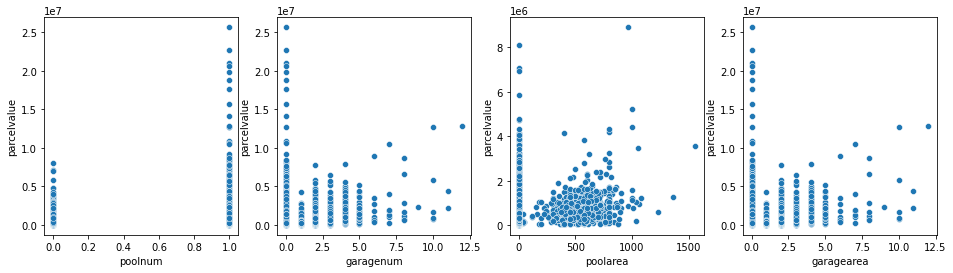

In [23]:
# Plot of the last changes
plt.figure(figsize=(16,4))
for i,col in enumerate(['poolnum', 'garagenum', 'poolarea', 'garagearea']):
    plt.subplot(1,4,i+1)
    sns.scatterplot(x=col, y='parcelvalue', data=df)

In [77]:
# Since there are many houses of almost 20 million with 0 garagenum and pooolarea I think the only useful feature here is poolnum
df.drop(['garagenum', 'poolarea', 'garagearea'], axis=1, inplace=True)

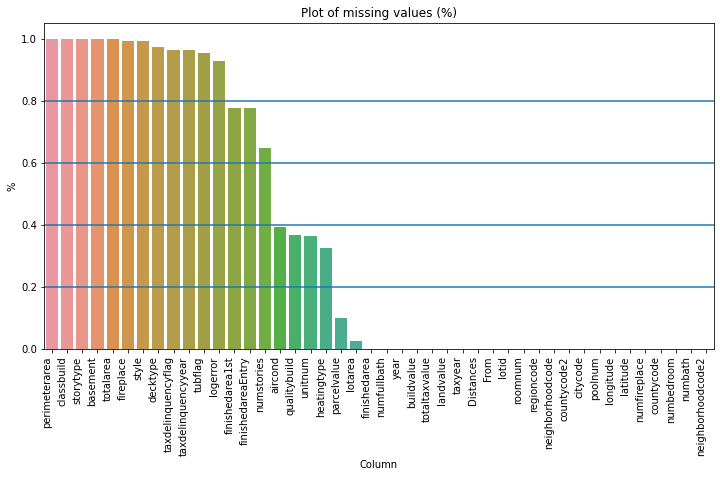

In [46]:
# Let's look at the variables at the missing values    
missing_plot(df)

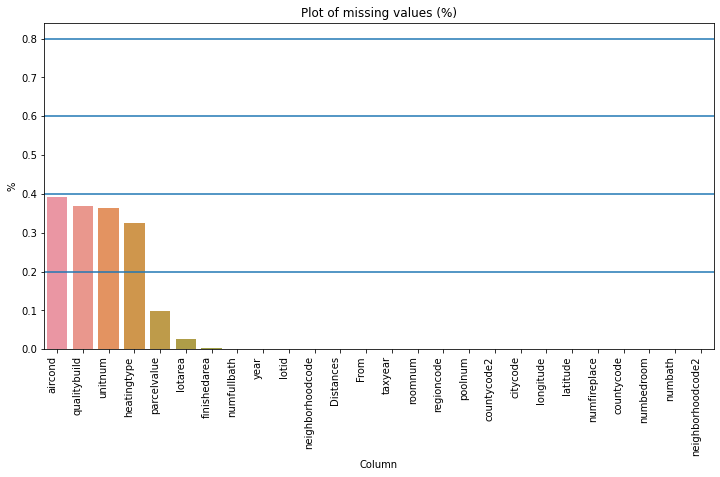

In [78]:
# I will erase columns with more than 60% of missing data
df.dropna(axis=1, thresh=round(0.4*len(df.index)), inplace=True) 
missing_plot(df)

In [79]:
# Fill na in finishedarea with the mean
print(df['finishedarea'].isnull().sum())
df['finishedarea'] = df['finishedarea'].fillna(df['finishedarea'].mean())
print(df['finishedarea'].isnull().sum())

63
0


In [80]:
# Fill na in lotarea with the mean
print(df['lotarea'].isnull().sum())
df['lotarea'] = df['lotarea'].fillna(df['lotarea'].mean())
print(df['lotarea'].isnull().sum())

709
0


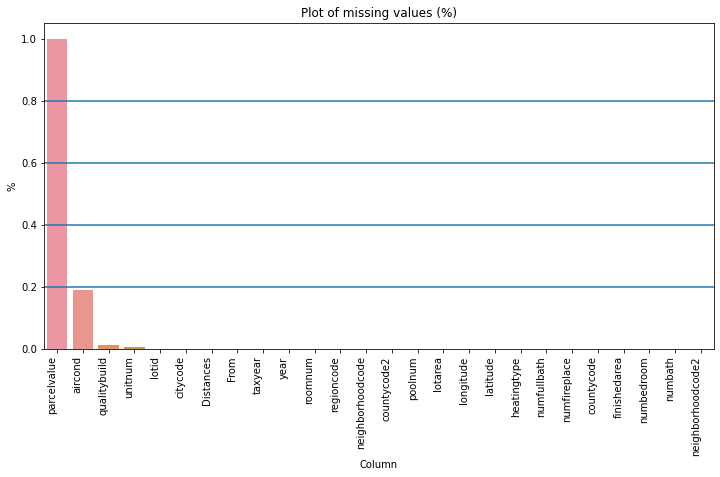

In [29]:
missing_plot(df[df['From'] == 'test'])

Almost 20% of the houses in test data dont have value for aircond, Since I did not see any relation with parcel value I prefer to delete this column

In [81]:
df.drop('aircond', axis=1, inplace=True)

In [82]:
# Now I will fil nas in qualitybuid and unitnum with the most common value only in test data,
# and delete rows with no values for those vars in train data
print(df.shape)
df2 = df[(df['From'] == 'test') |  ((df['qualitybuild'].isnull() == False) & (df['unitnum'].isnull() == False))].copy()
print(df2.shape)
print(df2['From'].value_counts())

(27501, 25)
(17388, 25)
training    14642
test         2746
Name: From, dtype: int64


In [83]:
# Fill the most common value in the rest of features
fill_max = ['qualitybuild', 'unitnum']
df2[fill_max] = df2[fill_max].apply(lambda x:x.fillna(x.value_counts().index[0]))
print(df2[fill_max].isnull().sum())

qualitybuild    0
unitnum         0
dtype: int64


In [84]:
df2.isnull().sum()

lotid                   0
numbath                 0
numbedroom              0
qualitybuild            0
finishedarea            0
countycode              0
numfireplace            0
numfullbath            17
heatingtype            17
latitude                0
longitude               0
lotarea                 0
poolnum                 0
citycode                0
countycode2             0
neighborhoodcode        0
regioncode              0
roomnum                 0
unitnum                 0
year                    0
parcelvalue          2746
taxyear                 0
From                    0
Distances               0
neighborhoodcode2       0
dtype: int64

In [85]:
# I will fill the remaining na's with the most common value
fill_max2 = ['numfullbath', 'heatingtype']
df2[fill_max2] = df2[fill_max2].apply(lambda x:x.fillna(x.value_counts().index[0]))
print(df2[fill_max2].isnull().sum())

numfullbath    0
heatingtype    0
dtype: int64


## 2.2 Data adjustments for running new regression

Since I have already deal with missing data I want to prepare the data to perform new estimations

In [86]:
# Cheking for data types
print(df2.select_dtypes('object').columns)
print(df2.select_dtypes('number').columns)

Index(['countycode', 'poolnum', 'citycode', 'countycode2', 'neighborhoodcode',
       'regioncode', 'From'],
      dtype='object')
Index(['lotid', 'numbath', 'numbedroom', 'qualitybuild', 'finishedarea',
       'numfireplace', 'numfullbath', 'heatingtype', 'latitude', 'longitude',
       'lotarea', 'roomnum', 'unitnum', 'year', 'parcelvalue', 'taxyear',
       'Distances', 'neighborhoodcode2'],
      dtype='object')


In [87]:
# I see that is not a good idea to have neighborhoodcode and neighborhoodcode2
# If want both information i just have to create a dummy for neighborhoodcode == missing
print((df2['neighborhoodcode'] == 'missing').value_counts())
df2['neighborhoodcode_missing'] = np.where(df2['neighborhoodcode'] == 'missing', 'True', 'False')
df2.drop('neighborhoodcode', axis=1, inplace=True)
df2['neighborhoodcode_missing'].value_counts()

False    15187
True      2201
Name: neighborhoodcode, dtype: int64


False    15187
True      2201
Name: neighborhoodcode_missing, dtype: int64

In [88]:
# Convert some types to its correct type
df2[['neighborhoodcode2','heatingtype']] = df2[['neighborhoodcode2','heatingtype']].astype('object')

In [89]:
# Now lets prepare the data to build new predictions

df2.reset_index(drop=True, inplace=True)

# Dummies for all non-numeric features in test data
cat_vars_list = [i for i in df2.select_dtypes('object') if i not in ['From']]
cat_vars = pd.get_dummies(df2[cat_vars_list].astype('object'))

numeric_vars_list = [i for i in df2.select_dtypes('number') if i not in ['lotid','parcelvalue', 'distances']]
numeric_scaled_vars = pd.DataFrame(scl(df2[numeric_vars_list]))

df_f2 = pd.concat([df2['lotid'], cat_vars, numeric_scaled_vars, df2['From'], df2['parcelvalue']], axis=1)

# Separate the df
df2_test_ = df_f2[df_f2['From'] == 'test'].copy()
df2_train_ = df_f2[df_f2['From'] == 'training'].copy()

parcelvalue = df2_train_['parcelvalue']
df2_test_.drop(['From', 'parcelvalue'], axis=1, inplace=True)
df2_train_.drop(['From', 'parcelvalue'], axis=1, inplace=True)

df2_train_.set_index('lotid', inplace=True)
df2_test_.set_index('lotid', inplace=True)

print(df2_test_.shape)
print(df2_train_.shape)
print(df_f2.shape)

(2746, 706)
(14642, 706)
(17388, 709)


In [91]:
X_train_2 = np.array(df2_train_).reshape(-1,706)
y_train_2 = np.array(parcelvalue).reshape(-1,1)
X_test_2 = np.array(df2_test_).reshape(-1,706)

## 2.3 Runing new models

### 2.3.1 Lasso over log of parcel value

In [383]:
la6 = Lasso(alpha=0.001, max_iter=1000000, random_state=123) 
la6.fit(X_train_2, np.log(y_train_2))

y_train_p_l6 = np.exp(la6.predict(X_train_2))
y_test_p_l6 = np.exp(la6.predict(X_test_2))

RMSE 158304114.91022807


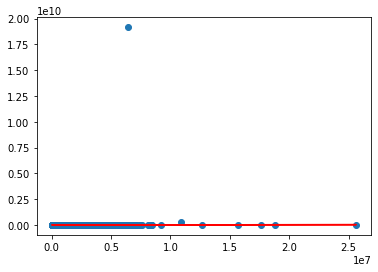

In [384]:
# Plot
plot_y(y_train_2, y_train_p_l6)

There is a value that is forecasted very high but it's really a lower value. Lets try to find it


In [387]:
df2_train_s = df2_train_.copy()
df2_train_s['Predicted_l6'] = y_train_p_l6
print(df2_train_s[df2_train_s['Predicted_l6'] > 1.57e10].index)

Int64Index([11887283], dtype='int64', name='lotid')


In [393]:
#df2[df2['lotid'] == 11887283]
for i in df2.columns:
    print(i)
    print(df2[df2['lotid'] == 11887283][i])

lotid
14583    11887283
Name: lotid, dtype: int64
numbath
14583    19.0
Name: numbath, dtype: float64
numbedroom
14583    10
Name: numbedroom, dtype: int64
qualitybuild
14583    12.0
Name: qualitybuild, dtype: float64
finishedarea
14583    31415.0
Name: finishedarea, dtype: float64
countycode
14583    6037
Name: countycode, dtype: object
numfireplace
14583    0
Name: numfireplace, dtype: int64
numfullbath
14583    19.0
Name: numfullbath, dtype: float64
heatingtype
14583    2.0
Name: heatingtype, dtype: float64
latitude
14583    34123811
Name: latitude, dtype: int64
longitude
14583   -118138122
Name: longitude, dtype: int64
lotarea
14583    56283.0
Name: lotarea, dtype: float64
poolnum
14583    1.0
Name: poolnum, dtype: object
citycode
14583    47019.0
Name: citycode, dtype: object
countycode2
14583    3101
Name: countycode2, dtype: object
regioncode
14583    96294.0
Name: regioncode, dtype: object
roomnum
14583    0
Name: roomnum, dtype: int64
unitnum
14583    1.0
Name: unitnum, dtype:

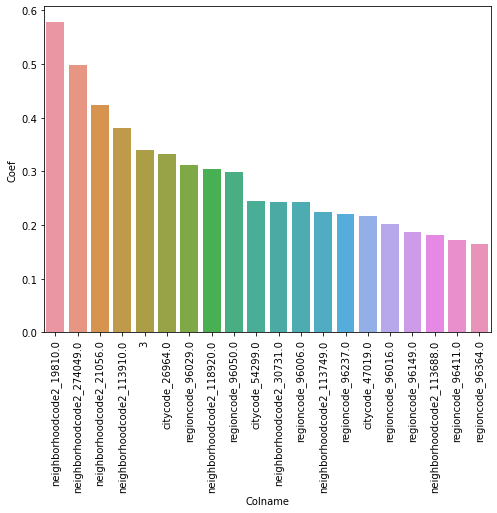

In [385]:
# Features importance in this model
feature_importance(df2_train_.columns, la6.coef_, 20)

The plot of features importance shows that neighborhoodcode2 is a good predictor of our target variable. So, it seems like filling the missing values as I did was a good idea.

In [394]:
test_predictions_submit_9 = pd.DataFrame({"lotid": df2_test_.index, "parcelvalue": y_test_p_l6.reshape(-1,)})
test_predictions_submit_9.to_csv("outputs/test_predictions_submit_19.csv", index = False)

This estimation gest a value of 403628. Let's see what happenps with the squared root tranformation of parcelvalue

### 2.3.2 Lasso over square root of parcel value

In [395]:
la7 = Lasso(alpha=0.1, max_iter=1000000, random_state=123) 
la7.fit(X_train_2, np.sqrt(y_train_2))

y_train_p_l7 = la7.predict(X_train_2) ** 2
y_test_p_l7 = la7.predict(X_test_2) ** 2

RMSE 508439.37921513274


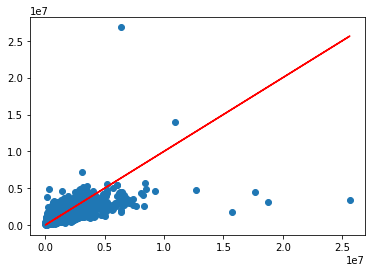

In [396]:
# Plot
plot_y(y_train_2, y_train_p_l7)

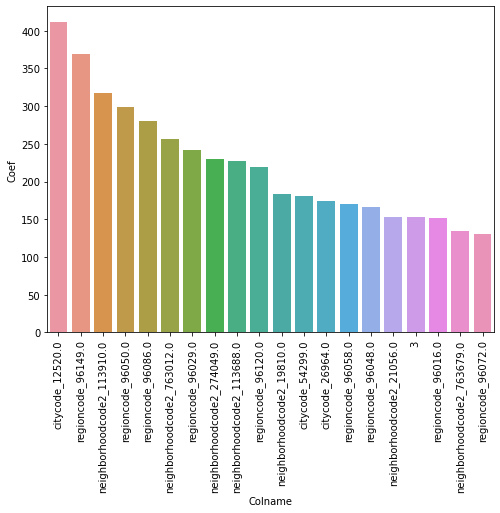

In [397]:
# Features importance in this model
feature_importance(df2_train_.columns, la7.coef_, 20)

In [398]:
test_predictions_submit_10 = pd.DataFrame({"lotid": df2_test_.index, "parcelvalue": y_test_p_l7.reshape(-1,)})
test_predictions_submit_10.to_csv("outputs/test_predictions_submit_110.csv", index = False)

This stimation gets a score of 390185.20563. The last estimations are not better that the first ones with just few cleaning of the data. 

Given the above results I can conclude that is better to work with the the squared root of parcel value

### 2.3.3 Plots of residuals

<AxesSubplot:ylabel='Count'>

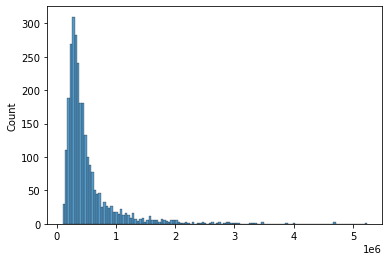

In [399]:
# Lets see the distribution of the predicted value for test
sns.histplot(y_test_p_l7.reshape(-1,))

<AxesSubplot:xlabel='Residuals_l7', ylabel='Count'>

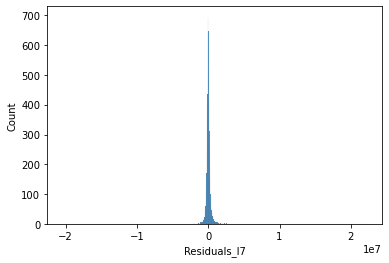

In [401]:
# Lets see the behaviuor of the residuals in the training data
df3_train_s = df2_train_.copy()
df3_train_s['Predicted_l7'] = y_train_p_l7
df3_train_s['parcelvalue'] = y_train_2
df3_train_s['Residuals_l7'] = df3_train_s['parcelvalue'] - df3_train_s['Predicted_l7']
sns.histplot(df3_train_s['Residuals_l7'])

<AxesSubplot:xlabel='parcelvalue', ylabel='Residuals_l7'>

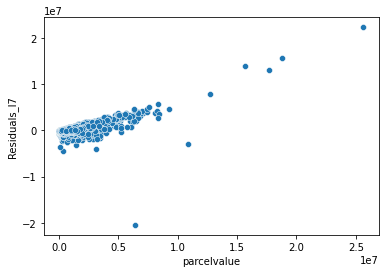

In [403]:
sns.scatterplot(x='parcelvalue', y='Residuals_l7', data=df3_train_s)

<AxesSubplot:xlabel='parcelvalue', ylabel='Residuals_l7'>

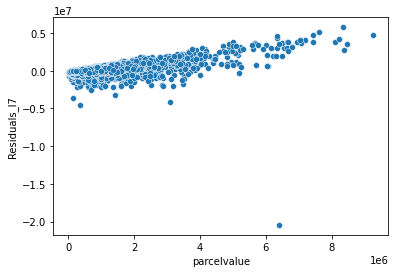

In [410]:
sns.scatterplot(x='parcelvalue', y='Residuals_l7', data=df3_train_s[df3_train_s['parcelvalue']<10e6])

From the plots above seems like the main problems with residuals are with houses over 10 million. So I will try to see if removing those houses improve my estimations

### 2.3.4 Lasso over square root of parcel value for those with parcel value < 10 million

In [431]:
df2_train_ajd = df2_train_.copy()
df2_train_ajd['parcelvalue'] = y_train_2

print(df2_train_ajd.shape)
df2_train_ajd = df2_train_ajd[df2_train_ajd['parcelvalue'] < 1e7]
parcelvalue_ajd = df2_train_ajd['parcelvalue']
df2_train_ajd.drop('parcelvalue', axis=1, inplace=True)

print(df2_train_ajd.shape)

(14642, 704)
(14636, 703)


In [432]:
X_train_3 = np.array(df2_train_ajd).reshape(-1,703)
y_train_3 = np.array(parcelvalue_ajd).reshape(-1,1)

In [438]:
## Lasso over square root of parcel value
la8 = Lasso(alpha=0.005, max_iter=1000000, random_state=123) 
la8.fit(X_train_3, np.sqrt(y_train_3))

y_train_p_l8 = la8.predict(X_train_3) ** 2
y_test_p_l8 = la8.predict(X_test_2) ** 2

RMSE 405219.2262656215


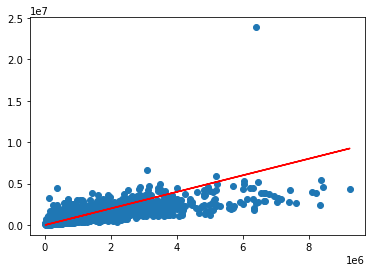

In [440]:
plot_y(y_train_3, y_train_p_l8)

In [441]:
test_predictions_submit_11 = pd.DataFrame({"lotid": df2_test_.index, "parcelvalue": y_test_p_l8.reshape(-1,)})
test_predictions_submit_11.to_csv("outputs/test_predictions_submit_111.csv", index = False)

This model gets 394022 in the leaderboard, not better that the model that keeps values higher than 10 million

# 3. Models with new variables

I want to do a further analysis and see if by creating new variables I can improve the score of the predictions.

## 3.1 Simple data exploration

<AxesSubplot:>

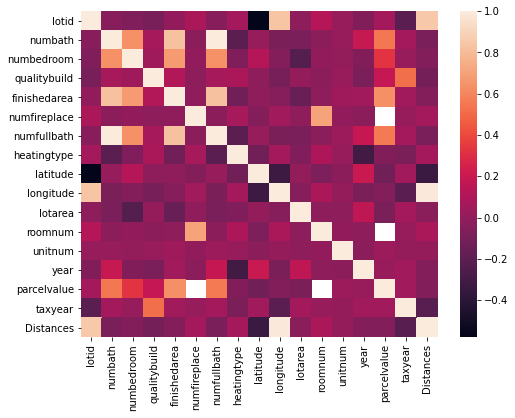

In [444]:
# Lets see the correlation among numeric variables
plt.figure(figsize=(8,6))
sns.heatmap(df2.select_dtypes('number').corr())

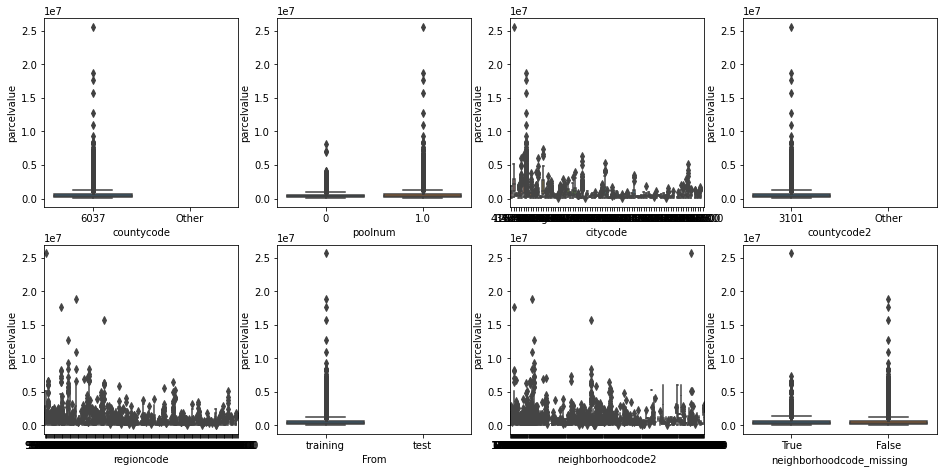

In [445]:
# Plots of categorical features
plt.figure(figsize=(16,16))
for i,col in enumerate(df2.select_dtypes('object').columns):
    plt.subplot(4,4,i+1)
    sns.boxplot(x=col, y='parcelvalue',data=df2)

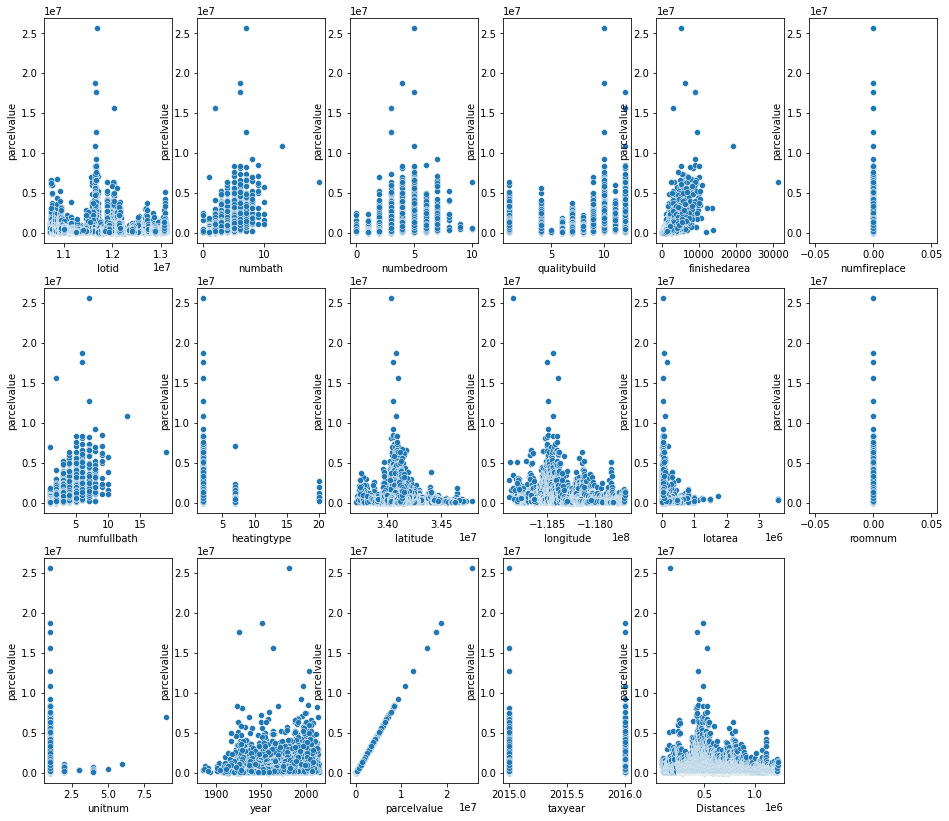

In [446]:
# Plots of numerical features
plt.figure(figsize=(16,24))
for i,col in enumerate(df2.select_dtypes('number').columns):
    plt.subplot(5,6,i+1)
    sns.scatterplot(x=col, y='parcelvalue', data=df2)

I would like to test if the interation of the variables could improve my predictions

## 3.2 Interaction between variables

In [92]:
# Creation of the interaction between  numeric variables
col_num = ['numbath', 'numbedroom', 'qualitybuild', 'finishedarea', 'numfullbath', 'year']
num_int_vars = list()
for col_i in col_num:
    for col_j in col_num:
        if col_i == col_j:
            pass
        else:
            df2[col_i+col_j] = df2[col_i] * df2[col_j]
            num_int_vars.append(col_i+col_j)

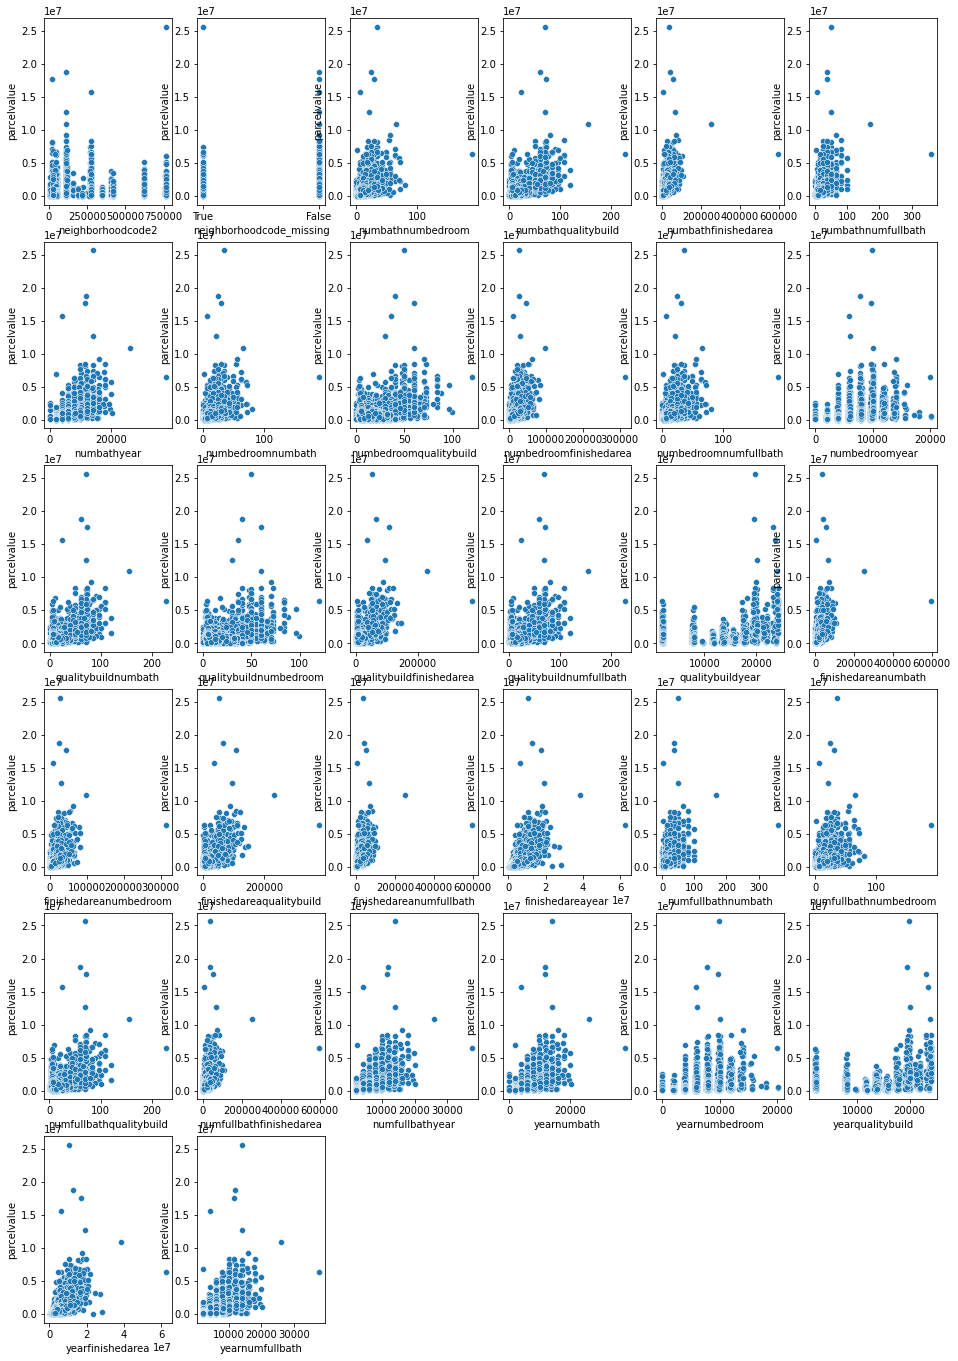

In [454]:
plt.figure(figsize=(16,24))
for i,col in enumerate(df2.columns[23:]):
    plt.subplot(6,6,i+1)
    sns.scatterplot(x=col, y='parcelvalue', data=df2)

## 3.3 Data preparation for new predictions

In [93]:
# Now lets prepare the data to build new predictions

df3 = df2.copy()
df3.reset_index(drop=True, inplace=True)

# Dummies for all non-numeric features in test data
cat_vars_list = [i for i in df3.select_dtypes('object') if i not in ['From']]
cat_vars = pd.get_dummies(df3[cat_vars_list].astype('object'))

numeric_vars_list = [i for i in df3.select_dtypes('number') if i not in ['lotid','parcelvalue', 'Distances']]
numeric_scaled_vars = pd.DataFrame(scl(df3[numeric_vars_list]))

df_f3 = pd.concat([df3['lotid'], cat_vars, numeric_scaled_vars, df3['From'], df3['parcelvalue']], axis=1)

# Separate the df
df3_test_ = df_f3[df_f3['From'] == 'test'].copy()
df3_train_ = df_f3[df_f3['From'] == 'training'].copy()

parcelvalue = df3_train_['parcelvalue']
df3_test_.drop(['From', 'parcelvalue'], axis=1, inplace=True)
df3_train_.drop(['From', 'parcelvalue'], axis=1, inplace=True)

df3_train_.set_index('lotid', inplace=True)
df3_test_.set_index('lotid', inplace=True)

print(df3_test_.shape)
print(df3_train_.shape)
print(df_f3.shape)

(2746, 735)
(14642, 735)
(17388, 738)


In [94]:
X_train_3 = np.array(df3_train_).reshape(-1,735)
y_train_3 = np.array(parcelvalue).reshape(-1,1)
X_test_3 = np.array(df3_test_).reshape(-1,735)

## 3.4 New lasso prediction over the squared root of parcel value

In [196]:
## Lasso over square root of parcel value
la9 = Lasso(alpha=0.1, max_iter=1000000, random_state=123) 
la9.fit(X_train_3, np.sqrt(y_train_3))

y_train_p_l9 = la9.predict(X_train_3) ** 2
y_test_p_l9 = la9.predict(X_test_3) ** 2

RMSE 474282.98920048657


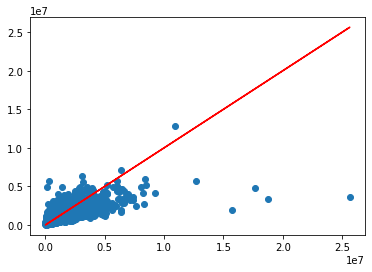

In [197]:
plot_y(y_train_3, y_train_p_l9)

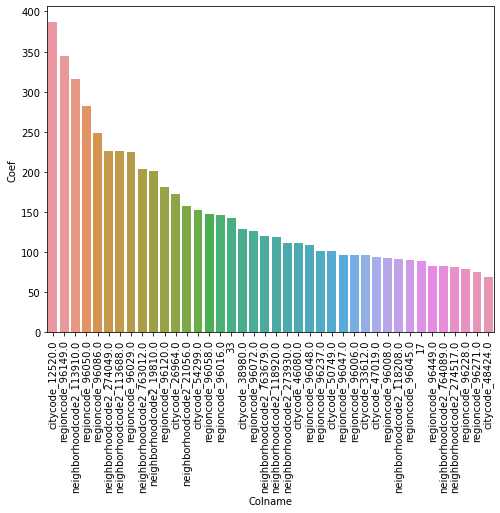

In [463]:
feature_importance(df3_train_.columns, la9.coef_, 40)

In [462]:
test_predictions_submit_12 = pd.DataFrame({"lotid": df3_test_.index, "parcelvalue": y_test_p_l9.reshape(-1,)})
test_predictions_submit_12.to_csv("outputs/test_predictions_submit_112.csv", index = False)

Good news! this model is better, the score is 388224. Since this estimation is better I think I could improve it more by doing grid searh to find the best value of alpha.

## 3.5 Grid search to find the best alpha for Lasso regression

In [96]:
lasso = Lasso(random_state=0, max_iter=1000000) 

alphas = np.array([0.01, 0.05,  0.1, 1]) # Small grid, takes too much time
tuned_parameters = [{'alpha': alphas}] 

mse = make_scorer(mean_squared_error, greater_is_better=False) # Not able to use rmse

n_folds = 3 # Only 3, I don't have much time :(

gs_1_lasso = GridSearchCV(lasso, tuned_parameters, scoring = mse, 
                   cv=n_folds, refit=False, verbose = 3)

In [97]:
# Findind the best alpha for this the model
gs_1_lasso.fit(X_train_3, np.sqrt(y_train_3))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END .....................................alpha=0.01; total time=10.0min
[CV 2/3] END .....................................alpha=0.01; total time=44.0min
[CV 3/3] END .....................................alpha=0.01; total time=15.8min
[CV 1/3] END .....................................alpha=0.05; total time= 2.6min
[CV 2/3] END .....................................alpha=0.05; total time= 1.6min
[CV 3/3] END .....................................alpha=0.05; total time= 1.1min
[CV 1/3] END ......................................alpha=0.1; total time= 3.5min
[CV 2/3] END ......................................alpha=0.1; total time=  38.8s
[CV 3/3] END ......................................alpha=0.1; total time=  52.4s
[CV 1/3] END ......................................alpha=1.0; total time=  15.8s
[CV 2/3] END ......................................alpha=1.0; total time= 1.3min
[CV 3/3] END ....................................

GridSearchCV(cv=3, estimator=Lasso(max_iter=1000000, random_state=0),
             param_grid=[{'alpha': array([0.01, 0.05, 0.1 , 1.  ])}],
             refit=False,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=3)

In [101]:
print(gs_1_lasso.cv_results_['mean_test_score'])
print(gs_1_lasso.best_params_['alpha'])
print(gs_1_lasso.best_params_)
print(gs_1_lasso.cv_results_['std_test_score'])

scores = gs_1_lasso.cv_results_['mean_test_score']
scores_std = gs_1_lasso.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(n_folds)

[-60488.304613   -59988.01305857 -59089.88586268 -63030.71489597]
0.1
{'alpha': 0.1}
[12898.09622754 16214.63766463 15588.43780879 15369.21091184]


(0.01, 1.0)

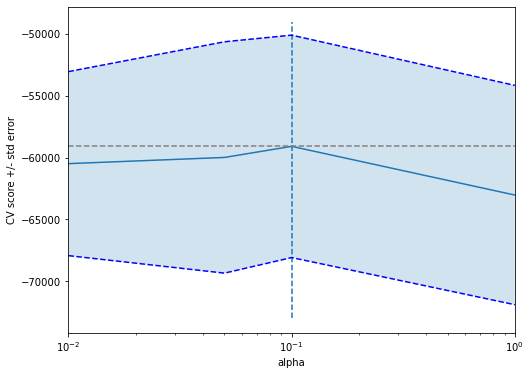

In [103]:
# Plot of the results
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
ymin, ymax = plt.ylim()
plt.vlines(gs_1_lasso.best_params_['alpha'] ,ymin, ymax, linestyle='dashed')
plt.xlim([alphas[0], alphas[-1]])

The grahp is not the best due I did not test many alphas. However, it shows that the best value for alpha is the same I already used alpha = 1. This is not good at all since I wanted to improve the predictions guessing that I was using a incorrect value of alpha.

It's time to try with a Ridge regression, which uses a different kind of regularization and can add more information to our estimations.

## 3.6 Ridge regression

I will do grid search to find the best value of the parameter of reguralization

### 3.6.1 Grid search for best alpha

In [150]:
rigde = Ridge(random_state=0, max_iter=1000000) 

alphas_rigde = np.array([0.001, 0.01, 0.5, 0.1, 1, 5, 10, 20, 50, 75, 100, 150, 200]) # bigger grid, it seems like ridge runs faster
tuned_parameters = [{'alpha': alphas_rigde}] 

mse = make_scorer(mean_squared_error, greater_is_better=False) # Not able to use rmse

n_folds = 5

gs_1_ridge = GridSearchCV(rigde, tuned_parameters, scoring = mse, 
                   cv=n_folds, refit=False, verbose = 3)

In [151]:
gs_1_ridge.fit(X_train_3, np.sqrt(y_train_3))

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ....................................alpha=0.001; total time=   0.6s
[CV 2/5] END ....................................alpha=0.001; total time=   0.5s
[CV 3/5] END ....................................alpha=0.001; total time=   0.6s
[CV 4/5] END ....................................alpha=0.001; total time=   0.5s
[CV 5/5] END ....................................alpha=0.001; total time=   0.5s
[CV 1/5] END .....................................alpha=0.01; total time=   0.5s
[CV 2/5] END .....................................alpha=0.01; total time=   0.5s
[CV 3/5] END .....................................alpha=0.01; total time=   0.5s
[CV 4/5] END .....................................alpha=0.01; total time=   0.5s
[CV 5/5] END .....................................alpha=0.01; total time=   0.5s
[CV 1/5] END ......................................alpha=0.5; total time=   0.5s
[CV 2/5] END ...................................

GridSearchCV(cv=5, estimator=Ridge(max_iter=1000000, random_state=0),
             param_grid=[{'alpha': array([1.0e-03, 1.0e-02, 5.0e-01, 1.0e-01, 1.0e+00, 5.0e+00, 1.0e+01,
       2.0e+01, 5.0e+01, 7.5e+01, 1.0e+02, 1.5e+02, 2.0e+02])}],
             refit=False,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=3)

In [152]:
print(gs_1_ridge.cv_results_['mean_test_score'])
print(gs_1_ridge.best_params_['alpha'])
print(gs_1_ridge.best_params_)
print(gs_1_ridge.cv_results_['std_test_score'])

scores = gs_1_ridge.cv_results_['mean_test_score']
scores_std = gs_1_ridge.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(n_folds)

[-65579.12577551 -63988.74537965 -50846.51641463 -56807.92370493
 -49163.98287816 -46745.80515819 -46056.94157472 -45583.72192414
 -45468.82119358 -45636.07164742 -45833.38428908 -46211.19529367
 -46540.24595566]
50.0
{'alpha': 50.0}
[18096.03357939 16812.08070112  8480.09920759 11282.86176194
  8147.49251454  7447.81078013  7175.60123071  6907.32475423
  6481.30593016  6299.04836005  6197.76452198  6118.66618467
  6116.26909659]


(0.001, 200.0)

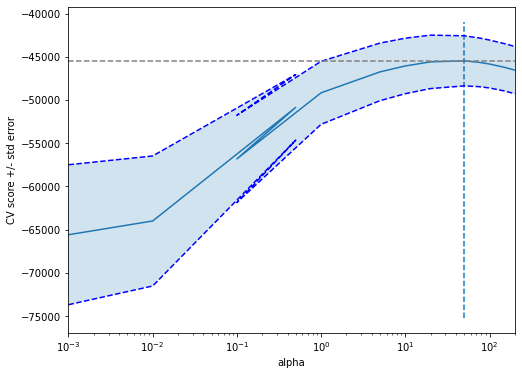

In [153]:
# Plot of the results
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas_rigde, scores)

# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas_rigde, scores + std_error, 'b--')
plt.semilogx(alphas_rigde, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas_rigde, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
ymin, ymax = plt.ylim()
plt.vlines(gs_1_ridge.best_params_['alpha'] ,ymin, ymax, linestyle='dashed')
plt.xlim([alphas_rigde[0], alphas_rigde[-1]])

The speed of Ridge hepls to test a large amount of alphas, here we see that at alpha = 50 the mse (hence the rmse) is the lowest. Now, I can make predictions and see the score in in-sample data and out-sample data.

### 3.6.2 Fiting the Ridge with the best alpha

In [154]:
## Ridge over square root of parcel value
Ri1 = Ridge(alpha=50, max_iter=1000000, random_state=123) # alpha = 1 is the default
Ri1.fit(X_train_3, np.sqrt(y_train_3))

y_train_p_R1 = Ri1.predict(X_train_3) ** 2
y_test_p_R1 = Ri1.predict(X_test_3) ** 2

RMSE 482596.4079750177


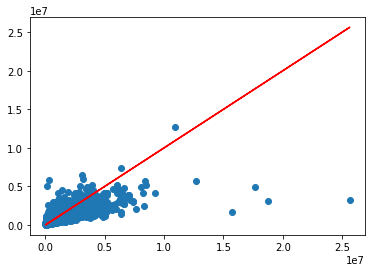

In [155]:
# RMSE and plot of observed vs. predicted y in training data
plot_y(y_train_3, y_train_p_R1)

In [156]:
test_predictions_submit_13 = pd.DataFrame({"lotid": df3_test_.index, "parcelvalue": y_test_p_R1.reshape(-1,)})
test_predictions_submit_13.to_csv("outputs/test_predictions_submit_113.csv", index = False)

The score is 393911 in the leaderboard, "good" and similiar to the last lasso regression. Now I want to improve the predictions by using the information of the best of the 13 different predictions made so far.

# 4. Predictions using the best predictions

For this step I have two ideas, use the average of the predictions to compute a new one and train a regression with the predictions in training data and then predict using the predictoins on the test data.

## 4.1 Predictions using the average of the best ones in the learderboard

In [157]:
# Loading the best predictions 
pred1_4 = pd.read_csv("outputs/test_predictions_submit_14.csv")
pred1_5 = pd.read_csv("outputs/test_predictions_submit_15.csv")
pred1_12 = pd.read_csv("outputs/test_predictions_submit_112.csv")
pred1_13 = pd.read_csv("outputs/test_predictions_submit_113.csv")

In [162]:
pred_df = pd.merge(pred1_4, pred1_5, on='lotid')
pred_df = pd.merge(pred_df, pred1_12, on='lotid')
pred_df = pd.merge(pred_df, pred1_13, on='lotid')
pred_df.head()

,lotid,parcelvalue_x,parcelvalue_y,parcelvalue_x,parcelvalue_y
0,11614222,682676.853261,672011.752044,606201.864698,584446.222122
1,11555888,441671.107010,523430.030166,538658.679144,547567.282136
2,13052987,317821.486312,307189.324289,265760.682961,273101.928315
3,12448473,252359.522662,251016.337152,269668.165915,272425.654370
4,12559155,240676.629152,221521.000408,185121.011466,184783.875503


In [171]:
# Rename the columns
pred_df.columns = ['lotid', 'pred_test_4', 'pred_test_5', 'pred_test_12', 'pred_test_13']
pred_df.head()

,lotid,pred_test_4,pred_test_5,pred_test_12,pred_test_13
0,11614222,682676.853261,672011.752044,606201.864698,584446.222122
1,11555888,441671.107010,523430.030166,538658.679144,547567.282136
2,13052987,317821.486312,307189.324289,265760.682961,273101.928315
3,12448473,252359.522662,251016.337152,269668.165915,272425.654370
4,12559155,240676.629152,221521.000408,185121.011466,184783.875503


<AxesSubplot:>

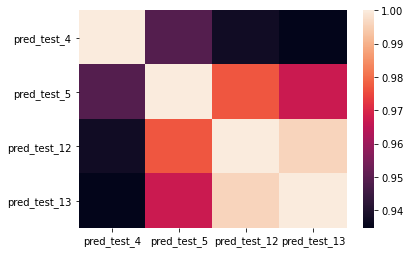

In [173]:
# Plot the scatter plot and the coeficient of correlation
sns.heatmap(pred_df.drop('lotid', axis=1).corr())

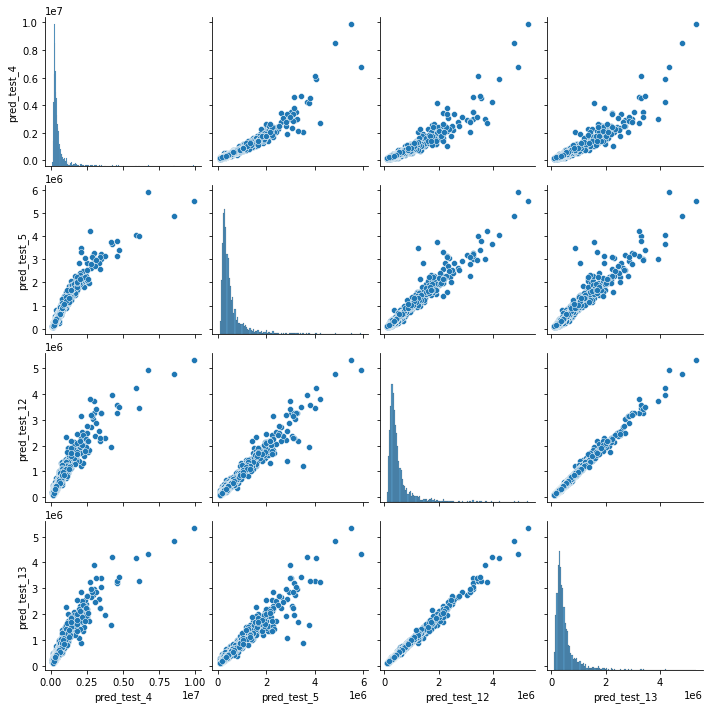

In [172]:
# Scatterplot of pair of predictions
sns.pairplot(pred_df.drop('lotid', axis=1))

Since the prediction 4 uses the log of parce value is very different from the others. I think that all of the predictions above can give good information to improve the rmse in the leaderboard.

In [186]:
# Computing the predictions
pred_df['pred_test_mean'] = (pred_df['pred_test_4'] + pred_df['pred_test_5'] + pred_df['pred_test_12'] + pred_df['pred_test_13']) / 4

test_predictions_submit_14 = pd.DataFrame({"lotid": pred_df['lotid'], "parcelvalue": pred_df['pred_test_mean']})
test_predictions_submit_14.to_csv("outputs/test_predictions_submit_114.csv", index = False)

The score obtained with this average is 384.969 which is the best in all of the submissions. Now lets try to improve by training a regresion model with the in-sample predictions.

## 4.2 Predictions runing a linear regression of the best predictions

### 4.2.1 Data pre-processing

In [193]:
# Building a df of the predictions in the training data (the training data set of this model)

# For the predictions in the part 2 of this notebook
dict_1_prlr = {'lotid':df_train_.index, 'pred_4':y_train_p_l2, 'pred_5':y_train_p_l3}
df_1_prlr = pd.DataFrame(dict_1_prlr)
df_1_prlr.head()

,lotid,pred_4,pred_5
0,11047729,235968.770449,2.725280e+05
1,11016338,314500.671466,3.305778e+05
2,11671803,777277.404826,1.098207e+06
3,11150386,373714.205498,3.987228e+05
4,10965295,251640.104593,2.357646e+05


<AxesSubplot:xlabel='pred_4', ylabel='pred_5'>

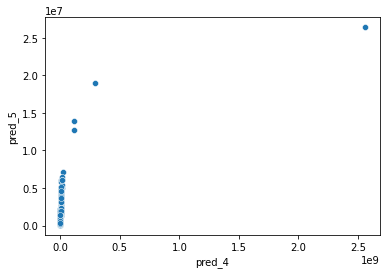

In [194]:
sns.scatterplot(x='pred_4', y='pred_5', data=df_1_prlr)

In [205]:
# For the predictions in the part 3 of this notebook incluiding the observe values
dict_2_prlr = {'lotid':df3_train_.index, 'pred_12':y_train_p_l9.reshape(-1), 'pred_13':y_train_p_R1.reshape(-1),
              'observed_y':y_train_3.reshape(-1)}
df_2_prlr = pd.DataFrame(dict_2_prlr)
df_2_prlr.head()

,lotid,pred_12,pred_13,observed_y
0,10748391,9.838750e+05,1.013192e+06,804849.0
1,10748479,9.757590e+05,9.907780e+05,1560000.0
2,10748355,1.343617e+06,1.386348e+06,1032581.0
3,10748453,1.348387e+06,1.397849e+06,1145921.0
4,10748471,1.501394e+06,1.564741e+06,1565000.0


<AxesSubplot:xlabel='pred_12', ylabel='pred_13'>

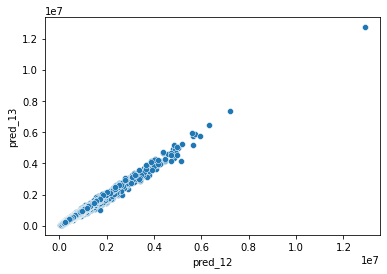

In [206]:
sns.scatterplot(x='pred_12', y='pred_13', data=df_2_prlr)

In [207]:
# Join the two data sets in the lotid in common
print(df_1_prlr.shape)
print(df_2_prlr.shape)
pred_df_train = pd.merge(df_1_prlr, df_2_prlr, on='lotid')
print(pred_df_train.shape)
pred_df_train.head()

(12560, 3)
(14642, 4)
(12469, 6)


,lotid,pred_4,pred_5,pred_12,pred_13,observed_y
0,11047729,235968.770449,2.725280e+05,3.134339e+05,317627.894658,270543.0
1,11016338,314500.671466,3.305778e+05,3.247584e+05,325485.478603,363524.0
2,11671803,777277.404826,1.098207e+06,1.034762e+06,951167.956598,329781.0
3,11150386,373714.205498,3.987228e+05,4.076831e+05,404771.805497,360647.0
4,10965295,251640.104593,2.357646e+05,2.452113e+05,245651.708923,186549.0


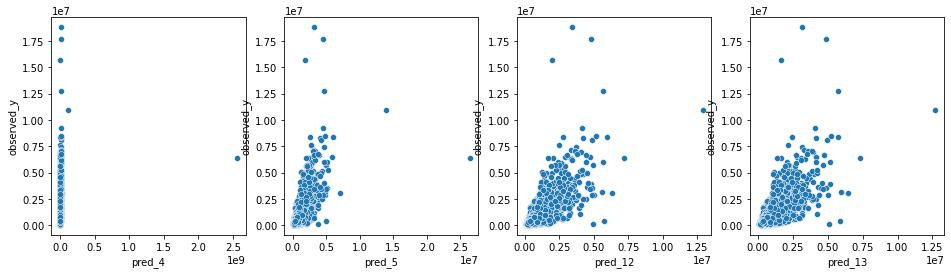

In [239]:
# Exploration of the data  
# sns pairplot is too slow for this amount of data
# Plan b
plt.figure(figsize=(16,4))
for i,col in enumerate(pred_df_train.columns[1:5]):
    plt.subplot(1,4,i+1)
    sns.scatterplot(x=col, y='observed_y', data=pred_df_train)

We had already seen these plots after training each model with inversed axis

In [212]:
# Preparing the test data 
pred_df_test = pred_df.copy()
pred_df_test.drop('pred_test_mean', axis=1, inplace=True)
pred_df_test.columns = ['lotid', 'pred_4', 'pred_5', 'pred_12', 'pred_13']
pred_df_test.head()

,lotid,pred_4,pred_5,pred_12,pred_13
0,11614222,682676.853261,672011.752044,606201.864698,584446.222122
1,11555888,441671.107010,523430.030166,538658.679144,547567.282136
2,13052987,317821.486312,307189.324289,265760.682961,273101.928315
3,12448473,252359.522662,251016.337152,269668.165915,272425.654370
4,12559155,240676.629152,221521.000408,185121.011466,184783.875503


### 4.2.2 Data adjustment before runnig the model

Here I want to standarize the data and creating the training and test arrays

In [262]:
X_train_nm = pred_df_train[['lotid', 'pred_4', 'pred_5', 'pred_12', 'pred_13']].copy()
X_train_nm.set_index('lotid', inplace=True)

y_train_nm = pred_df_train['observed_y'].copy()

X_test_nm = pred_df_test.copy()
X_test_nm.set_index('lotid', inplace=True)

print(X_train_nm.shape)
print(X_test_nm.shape)
print(y_train_nm.shape)

(12469, 4)
(2746, 4)
(12469,)


### 4.2.1 Linear regression to weigh each prediction

In [263]:
## Linear regression over the square root of parcel value
la10 = LinearRegression() 
la10.fit(X_train_nm, y_train_nm)

y_train_p_l10 = la10.predict(X_train_nm)
y_test_p_l10 = la10.predict(X_test_nm)

RMSE 437103.8727882402


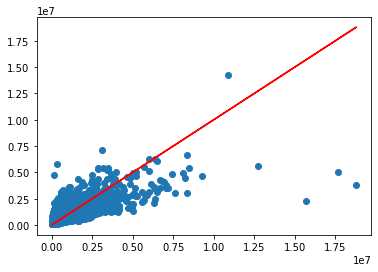

In [264]:
plot_y(y_train_nm, y_train_p_l10)

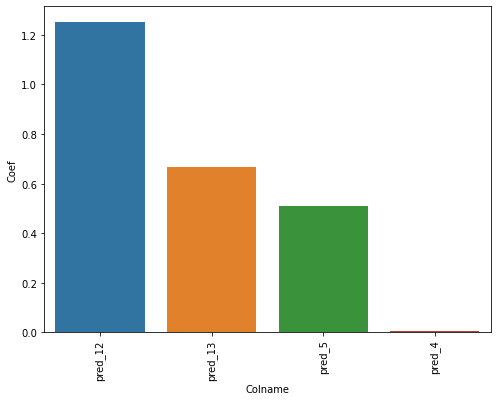

In [265]:
feature_importance(X_train_nm.columns, la10.coef_, 4)

Since, all the columns are in the same levels I think that makes sense the plot of features importance, which says that the model 12 (lasso regression with all the preprocessing) weights more in the predictions.

In [252]:
test_predictions_submit_15 = pd.DataFrame({"lotid": X_test_nm.index, "parcelvalue": y_test_p_l10.reshape(-1,)})
test_predictions_submit_15.to_csv("outputs/test_predictions_submit_115.csv", index = False)

With this approximation I have a slight improvement in the leaderboard score (382380)

# 5. Final remarks

I have tried to process the data to have as most useful information as possible. I think that the main challenge of this project is to deal with the outliers. 

Running several predictions and using then as a new prediction by the average or weighting them by a linear regression make slight improvements in the score in the leaderboard.